# Individual Category Time Series Modelling
Use the most up-to-date CPI data from the Stats SA website. Investigate each category individualy and compare the forcasts from the Holt-Winters with an ARIMA model.

Determine which additional data can be used to improve the forecasting for each category and where necessary fit a VAR or VARMA model after making the time series stationary.

## Import Libraries

In [1]:
# Import libraries
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd


from pandas.plotting import register_matplotlib_converters
from pandas_datareader.data import DataReader
import pandas_datareader as pdr


# Import Statsmodels
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.statespace.sarimax import SARIMAX

import pmdarima as pm
from pmdarima.arima.utils import nsdiffs

from sklearn.metrics import mean_squared_error
from math import sqrt

# plt.style.use("seaborn")
# register_matplotlib_converters()

# Import packages
import plotly.graph_objects as go

# import nbformat
import plotly.io as pio
pio.renderers.default='notebook_connected'

#suppress warnings
# import warnings
# warnings.filterwarnings('ignore')

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## Import the Different Data Sets
Import the following data sets:

- `EXCEL - CPI(5 and 8 digit) from Jan 2017 (202306).xlsx`: this will be used to do the EDA and predictions of the CPI values.
- `CPI_Historic_Values_Zindi_May_23.csv`: this data was provided on the Zindi website and will be used to confirm that the calculations on the raw data is correct.
- `Zindi_CPI_Predictions_July.csv`: this data is the example predictions for the April 2023 data on Zindi and will be used to compare the predictions from the simple model.

In [3]:
raw_df = pd.read_excel("EXCEL - CPI(5 and 8 digit) from Jan 2017 (202306).xlsx", dtype="object")
historic_zindi_cpi_df= pd.read_csv("CPI_Historic_Values_Zindi_May_23.csv")
pred_zindi_july_df = pd.read_csv("Zindi_CPI_Predictions_July.csv")

## Review the Historical CPI data and Create a Summary DataFrame
There are 12 main categories that are used to calculate the Headline CPI. Each category has a number of sub categories. This data set contains the CPI on sub-category level.

Create a dataset where the CPI is calculated on the category level. These values will then be used in the models to predict the CPI for the different categories as well as the Headline CPI.

In terms of cleaning the data, I will do the following:
- Remove unnecessary columns.
- Change column headers to make them more explanatory.
- Replace all `..` entries with a `0`. 
- Combine the `Super maize` and `Special maize` categories into a single `Maize meal` category, to correspond with the current use of maize meal.
- Create a function to calculate the CPI values for each month using the weights provided in the file.

#### 1. Drop unnecessary columns & rename columns

In [4]:
raw_df.shape

(226, 86)

In [5]:
list_cols_to_drop = ['H01','H02','H05','H06','H07']
cat_cpi_df = raw_df.drop(list_cols_to_drop, axis=1).copy()

In [6]:
cat_cpi_df.rename(columns = {'H03':'category_codes', 'H04':'category_descr', 
                             'Weight (All urban)':'weights_urban'}, inplace = True)

#### 2. Replace all `..` entries with a `0`
There are products which were included in the CPI calculations at a later stage and some products that were removed from the CPI calculation. Categories with no value at the time has a .., I will replace them with a 0. The type of the column can then be updated to float.

In [7]:
# find all '..' entries in the dataframe
cat_cpi_df[cat_cpi_df.eq('..').any(axis=1)]

category_codes                                     category_descr  \
15        01116003                                         Maize meal   
17        01116008                                        Super maize   
18        01116009                                      Special maize   
21        01116012                                               Samp   
97        01182001                                                Jam   
116       01193008                 Baby food - pureed bottled/pouched   
119       01211003                                  Cappucino sachets   
129       01223003                              Dairy blends/mixtures   
137       02122002                                                Gin   
192          09111  Equipment for reception, recording and reprodu...   

    weights_urban M201701 M201702 M201703 M201704 M201705 M201706 M201707  \
15           0.76      ..      ..      ..      ..      ..      ..      ..   
17             ..   118.4     119   116.4   112.9     108   104.2     101   
18             ..     126   126.2   121.1   116.5   118.8   116.8   104.5   
21           0.01      ..      ..      ..      ..      ..      ..      ..   
97           0.02      ..      ..      ..      ..      ..      ..      ..   
116          0.05      ..      ..      ..      ..      ..      ..      ..   
119          0.03      ..      ..      ..      ..      ..      ..      ..   
129          0.07      ..      ..      ..      ..      ..      ..      ..   
137          0.10      ..      ..      ..      ..      ..      ..      ..   
192          0.05      ..      ..      ..      ..      ..      ..      ..   

     ... M202209 M202210 M202211 M202212 M202301 M202302 M202303 M202304  \
15   ...   126.2   128.4   131.2   133.7   137.9     141   142.3   142.4   
17   ...      ..      ..      ..      ..      ..      ..      ..      ..   
18   ...      ..      ..      ..      ..      ..      ..      ..      ..   
21   ...   120.8   120.6   122.9   125.9   130.4   132.7   135.9   134.1   
97   ...   110.8   110.4   110.9   109.6   110.7   110.8     113   112.4   
116  ...   111.3   112.8   112.8   112.7   112.9   113.1   113.4   116.5   
119  ...     111   112.8   113.2   112.3   114.1   115.3   115.8   117.2   
129  ...   114.9   119.5   121.4   120.4   120.2   122.7   119.9   120.2   
137  ...   107.1   107.8     108   107.3   108.2   107.8   108.9   110.5   
192  ...    99.2    98.2      98      96    99.3     100    99.9    98.3   

    M202305 M202306  
15    142.9   143.1  
17       ..      ..  
18       ..      ..  
21    135.1   136.9  
97    114.6   114.7  
116   117.9   119.4  
119   117.7   118.9  
129   121.6   125.8  
137   111.9   111.3  
192    97.9    97.9  

[10 rows x 81 columns]

In [8]:
cat_cpi_df.replace("..", 0, inplace=True)

In [9]:
cat_cpi_df[cat_cpi_df.eq(0).any(axis=1)]

category_codes                                     category_descr  \
15        01116003                                         Maize meal   
17        01116008                                        Super maize   
18        01116009                                      Special maize   
21        01116012                                               Samp   
97        01182001                                                Jam   
116       01193008                 Baby food - pureed bottled/pouched   
119       01211003                                  Cappucino sachets   
129       01223003                              Dairy blends/mixtures   
137       02122002                                                Gin   
192          09111  Equipment for reception, recording and reprodu...   

    weights_urban  M201701  M201702  M201703  M201704  M201705  M201706  \
15           0.76      0.0      0.0      0.0      0.0      0.0      0.0   
17              0    118.4    119.0    116.4    112.9    108.0    104.2   
18              0    126.0    126.2    121.1    116.5    118.8    116.8   
21           0.01      0.0      0.0      0.0      0.0      0.0      0.0   
97           0.02      0.0      0.0      0.0      0.0      0.0      0.0   
116          0.05      0.0      0.0      0.0      0.0      0.0      0.0   
119          0.03      0.0      0.0      0.0      0.0      0.0      0.0   
129          0.07      0.0      0.0      0.0      0.0      0.0      0.0   
137          0.10      0.0      0.0      0.0      0.0      0.0      0.0   
192          0.05      0.0      0.0      0.0      0.0      0.0      0.0   

     M201707  ...  M202209  M202210  M202211  M202212  M202301  M202302  \
15       0.0  ...    126.2    128.4    131.2    133.7    137.9    141.0   
17     101.0  ...      0.0      0.0      0.0      0.0      0.0      0.0   
18     104.5  ...      0.0      0.0      0.0      0.0      0.0      0.0   
21       0.0  ...    120.8    120.6    122.9    125.9    130.4    132.7   
97       0.0  ...    110.8    110.4    110.9    109.6    110.7    110.8   
116      0.0  ...    111.3    112.8    112.8    112.7    112.9    113.1   
119      0.0  ...    111.0    112.8    113.2    112.3    114.1    115.3   
129      0.0  ...    114.9    119.5    121.4    120.4    120.2    122.7   
137      0.0  ...    107.1    107.8    108.0    107.3    108.2    107.8   
192      0.0  ...     99.2     98.2     98.0     96.0     99.3    100.0   

     M202303  M202304  M202305  M202306  
15     142.3    142.4    142.9    143.1  
17       0.0      0.0      0.0      0.0  
18       0.0      0.0      0.0      0.0  
21     135.9    134.1    135.1    136.9  
97     113.0    112.4    114.6    114.7  
116    113.4    116.5    117.9    119.4  
119    115.8    117.2    117.7    118.9  
129    119.9    120.2    121.6    125.8  
137    108.9    110.5    111.9    111.3  
192     99.9     98.3     97.9     97.9  

[10 rows x 81 columns]

#### 3. Combine the Maize categories

In [10]:
cat_cpi_df.shape

(226, 81)

In [11]:
# Convert the Super maize and Special maize row to numeric data types.
# The rows will be dropped, so the loss of other information is not a problem.

cat_cpi_df.iloc[17:19] = cat_cpi_df.iloc[17:19].apply(pd.to_numeric, errors='coerce')

# Divide rows A and B
divided_row = (cat_cpi_df.iloc[17]+cat_cpi_df.iloc[18])/2

# Replace the value in row C if it is 0 with the divided value
cat_cpi_df.iloc[15] = [divided_row[i] if value == 0 else value for i, value in enumerate(cat_cpi_df.iloc[15])]

# Remove the rows for Super maize and Special maize
cat_cpi_df.drop([cat_cpi_df.index[17], cat_cpi_df.index[18]], inplace=True)
print(cat_cpi_df.shape)

(224, 81)


In [12]:
# check
cat_cpi_df.iloc[15, 3:-2].sum()
# 7844.05

7844.050000000002

In [13]:
# check
cat_cpi_df.iloc[17:19]

category_codes                                category_descr weights_urban  \
19       01116010  Hot cereals (porridge) incl instant porridge          0.05   
20       01116011                               Ready-mix flour          0.01   

    M201701  M201702  M201703  M201704  M201705  M201706  M201707  ...  \
19     84.4     83.2     83.8     84.1     84.4     84.9     82.1  ...   
20     83.2     82.7     83.0     82.6     82.8     82.5     82.5  ...   

    M202209  M202210  M202211  M202212  M202301  M202302  M202303  M202304  \
19    112.3    112.4    114.6    115.5    113.1    116.6    118.4    120.6   
20    116.1    116.0    115.1    115.0    115.9    119.0    118.1    119.3   

    M202305  M202306  
19    127.4    124.5  
20    120.5    116.5  

[2 rows x 81 columns]

#### 4. Create a function to calculate the category and headline CPI for each month
Use the logic provided by StatsSA and the weights provided in the data to calculate the CPI for each month.

In [14]:
# Create a category dictionary with the category code and description
category_dict = {"01":"Food and non-alcoholic beverages",
                 "02":"Alcoholic beverages and tobacco",
                 "03":"Clothing and footwear",
                 "04":"Housing and utilities",
                 "05":"Household contents and services",
                 "06":"Health",
                 "07":"Transport",
                 "08":"Communication",
                 "09":"Recreation and culture",
                 "10":"Education",
                 "11":"Restaurants and hotels",
                 "12":"Miscellaneous goods and services",
                 "headline": "headline CPI"
}

In [15]:
# Convert the 'weights_urban' column to float
cat_cpi_df['weights_urban'] = cat_cpi_df['weights_urban'].astype('float')

In [16]:
def create_monthly_cpi(input_df):
    """Create a dataframe with the headline CPI and category CPI values using the raw data as input"""
    
    # Make a copy of the input dataframe
    df = input_df.copy()
    
    # Assign a main category code to each raw data row.
    main_category = []
    for index, row in cat_cpi_df.iterrows():
        if (len(row['category_codes']) == 8) & (row['category_codes'][:2] in ["01","02"]):
            main_category.append(row['category_codes'][:2])
        elif (len(row['category_codes']) == 5):  # & (row['category_codes'][:2] not in ["04","07"]):
            main_category.append(row['category_codes'][:2])
        else:
            main_category.append("no")
    
    df['main_category_code'] = main_category
    
    # Drop the rows where the main_category_code is "no". That is to prevent double counting.
    # Some categories have a sub category included in the data.
    df.drop(df[df['main_category_code'] == "no"].index, inplace = True)
    
    # Sum the weights for each category
    sum_weights = df.groupby('main_category_code')['weights_urban'].sum()
    
    cpi_df = pd.DataFrame()
    
    # For each month create the headline CPI value and the CPI value per category. 
    for col in range(3, df.shape[1]-1):
        column_name = df.columns[col]
        df['weighted_index_' + column_name] = df['weights_urban']*df[column_name]
    
        sum_weighted_index = df.groupby('main_category_code')['weighted_index_' + column_name].sum()
        
        # Concatenate the DataFrames horizontally
        concat_df = pd.concat([sum_weights, sum_weighted_index], axis=1)
        
        # Add a row that sums the values in the columns
        sums_df = pd.DataFrame(concat_df.sum().values.reshape(1, -1), columns=concat_df.columns)
        sums_df = sums_df.set_index(pd.Index(["headline"]))
        
        # Concatenate the headline dataframe to the categories
        month_cpi_df = pd.concat([concat_df, sums_df], axis=0) 
        
        # Calculate the CPI value
        month_cpi_df['cpi_'+column_name] = (month_cpi_df['weighted_index_' + column_name] / 
                                            month_cpi_df['weights_urban']).round(1)
        
        cpi_df = pd.concat([cpi_df, month_cpi_df[['weights_urban', 'cpi_'+column_name]]], axis=1)
    
    # Remove duplicate weights columns and reset the index
    cpi_df = cpi_df.loc[:, ~cpi_df.columns.duplicated()]
    cpi_df = cpi_df.reset_index().rename(columns={'index':'category'})
    
    # Dataframe with just the CPI values:
    cpi_df = cpi_df.drop('weights_urban', axis=1).copy()
    
    return(cpi_df)

In [17]:
cpi_summary_df = create_monthly_cpi(cat_cpi_df)

In [18]:
cpi_summary_df

category  cpi_M201701  cpi_M201702  cpi_M201703  cpi_M201704  cpi_M201705  \
0         01         81.6         82.2         82.4         82.3         82.7   
1         02         78.5         78.3         79.5         80.1         80.3   
2         03         92.7         93.0         93.3         93.3         93.5   
3         04         82.1         82.1         82.8         82.8         82.8   
4         05         90.5         90.2         90.7         90.5         90.6   
5         06         79.3         82.3         83.0         83.4         83.6   
6         07         76.7         77.3         77.2         77.0         77.8   
7         08        103.7        103.6        102.9        102.9        102.7   
8         09         95.9         96.1         96.2         96.4         96.3   
9         10         74.2         74.2         79.4         79.4         79.4   
10        11         88.2         89.3         89.4         89.2         88.5   
11        12         78.4         81.6         81.7         82.0         82.0   
12  headline         82.4         83.1         83.6         83.6         83.8   

    cpi_M201706  cpi_M201707  cpi_M201708  cpi_M201709  ...  cpi_M202209  \
0          82.6         82.6         82.3         82.3  ...        110.3   
1          80.4         80.6         81.7         82.0  ...        105.6   
2          93.5         93.5         93.6         93.7  ...        102.4   
3          83.6         84.5         84.5         85.3  ...        103.8   
4          91.2         91.1         90.9         91.3  ...        104.5   
5          83.8         84.0         83.8         84.0  ...        104.0   
6          77.5         76.6         76.9         78.1  ...        112.0   
7         102.4        102.3        102.1        101.9  ...         99.9   
8          96.5         96.5         96.5         96.3  ...        102.5   
9          79.4         79.4         79.4         79.4  ...        104.4   
10         88.7         89.4         89.6         89.3  ...        106.3   
11         82.1         82.5         82.5         82.6  ...        103.9   
12         84.0         84.2         84.2         84.6  ...        106.1   

    cpi_M202210  cpi_M202211  cpi_M202212  cpi_M202301  cpi_M202302  \
0         111.3        112.0        112.4        114.4        115.5   
1         106.1        106.4        106.2        106.5        106.9   
2         102.7        102.6        102.8        102.9        103.5   
3         103.8        103.8        104.1        104.1        104.2   
4         105.0        105.2        106.1        106.6        106.6   
5         104.5        104.7        104.7        104.9        108.5   
6         111.7        113.1        113.9        109.9        110.6   
7          99.8         99.2         99.1         99.4         99.8   
8         102.7        102.8        103.4        103.4        103.3   
9         104.4        104.4        104.4        104.4        104.4   
10        107.5        108.0        107.8        106.8        108.8   
11        104.6        104.7        104.9        105.4        107.7   
12        106.5        106.8        107.2        107.1        107.9   

    cpi_M202303  cpi_M202304  cpi_M202305  cpi_M202306  
0         116.7        117.4        117.7        118.3  
1         109.2        110.2        110.6        110.9  
2         103.4        103.7        104.1        104.3  
3         104.5        104.6        104.6        105.4  
4         107.8        107.7        107.5        107.7  
5         109.1        109.5        110.3        110.8  
6         112.9        113.1        113.3        112.3  
7          99.7         99.8         99.7         99.6  
8         104.3        104.9        104.8        105.3  
9         110.4        110.4        110.4        110.4  
10        109.6        108.6        110.5        110.0  
11        107.8        109.3        109.4        109.6  
12        109.0        109.4        109.6        109.8  

[13 rows x

In [19]:
# Transpose the dataframe so that each category is a separate column.
transposed_cpi_df = cpi_summary_df.set_index('category').transpose()
transposed_cpi_df.tail()

category        01     02     03     04     05     06     07    08     09  \
cpi_M202302  115.5  106.9  103.5  104.2  106.6  108.5  110.6  99.8  103.3   
cpi_M202303  116.7  109.2  103.4  104.5  107.8  109.1  112.9  99.7  104.3   
cpi_M202304  117.4  110.2  103.7  104.6  107.7  109.5  113.1  99.8  104.9   
cpi_M202305  117.7  110.6  104.1  104.6  107.5  110.3  113.3  99.7  104.8   
cpi_M202306  118.3  110.9  104.3  105.4  107.7  110.8  112.3  99.6  105.3   

category        10     11     12  headline  
cpi_M202302  104.4  108.8  107.7     107.9  
cpi_M202303  110.4  109.6  107.8     109.0  
cpi_M202304  110.4  108.6  109.3     109.4  
cpi_M202305  110.4  110.5  109.4     109.6  
cpi_M202306  110.4  110.0  109.6     109.8

##### Change the row index to be in date format

In [20]:
monthly_cpi_df = transposed_cpi_df.copy()

In [21]:
# Reset the index so that the row index becomes a column
monthly_cpi_df.reset_index(inplace=True)

In [22]:
# Rename category column to 'month' and update the entries by removing the first digits and only keeping the date.
monthly_cpi_df.rename(columns = {'index':'year_month'}, inplace = True)
monthly_cpi_df['year_month'] = monthly_cpi_df['year_month'].str[5:]

In [23]:
# Change format of 'year_month' to a datetime format
monthly_cpi_df['year_month'] = pd.to_datetime(monthly_cpi_df['year_month'], format='%Y%m')
# monthly_cpi_df['year_month'] = pd.to_datetime(monthly_cpi_df['year_month'], format='%Y%m').dt.to_period('M')

In [24]:
# make the year-month the index again
monthly_cpi_df = monthly_cpi_df.set_index('year_month')
monthly_cpi_df.index = pd.DatetimeIndex(monthly_cpi_df.index.values, freq=monthly_cpi_df.index.inferred_freq)

In [25]:
monthly_cpi_df

category       01     02     03     04     05     06     07     08     09  \
2017-01-01   81.6   78.5   92.7   82.1   90.5   79.3   76.7  103.7   95.9   
2017-02-01   82.2   78.3   93.0   82.1   90.2   82.3   77.3  103.6   96.1   
2017-03-01   82.4   79.5   93.3   82.8   90.7   83.0   77.2  102.9   96.2   
2017-04-01   82.3   80.1   93.3   82.8   90.5   83.4   77.0  102.9   96.4   
2017-05-01   82.7   80.3   93.5   82.8   90.6   83.6   77.8  102.7   96.3   
...           ...    ...    ...    ...    ...    ...    ...    ...    ...   
2023-02-01  115.5  106.9  103.5  104.2  106.6  108.5  110.6   99.8  103.3   
2023-03-01  116.7  109.2  103.4  104.5  107.8  109.1  112.9   99.7  104.3   
2023-04-01  117.4  110.2  103.7  104.6  107.7  109.5  113.1   99.8  104.9   
2023-05-01  117.7  110.6  104.1  104.6  107.5  110.3  113.3   99.7  104.8   
2023-06-01  118.3  110.9  104.3  105.4  107.7  110.8  112.3   99.6  105.3   

category       10     11     12  headline  
2017-01-01   74.2   88.2   78.4      82.4  
2017-02-01   74.2   89.3   81.6      83.1  
2017-03-01   79.4   89.4   81.7      83.6  
2017-04-01   79.4   89.2   82.0      83.6  
2017-05-01   79.4   88.5   82.0      83.8  
...           ...    ...    ...       ...  
2023-02-01  104.4  108.8  107.7     107.9  
2023-03-01  110.4  109.6  107.8     109.0  
2023-04-01  110.4  108.6  109.3     109.4  
2023-05-01  110.4  110.5  109.4     109.6  
2023-06-01  110.4  110.0  109.6     109.8  

[78 rows x 13 columns]

#### Plot the Data

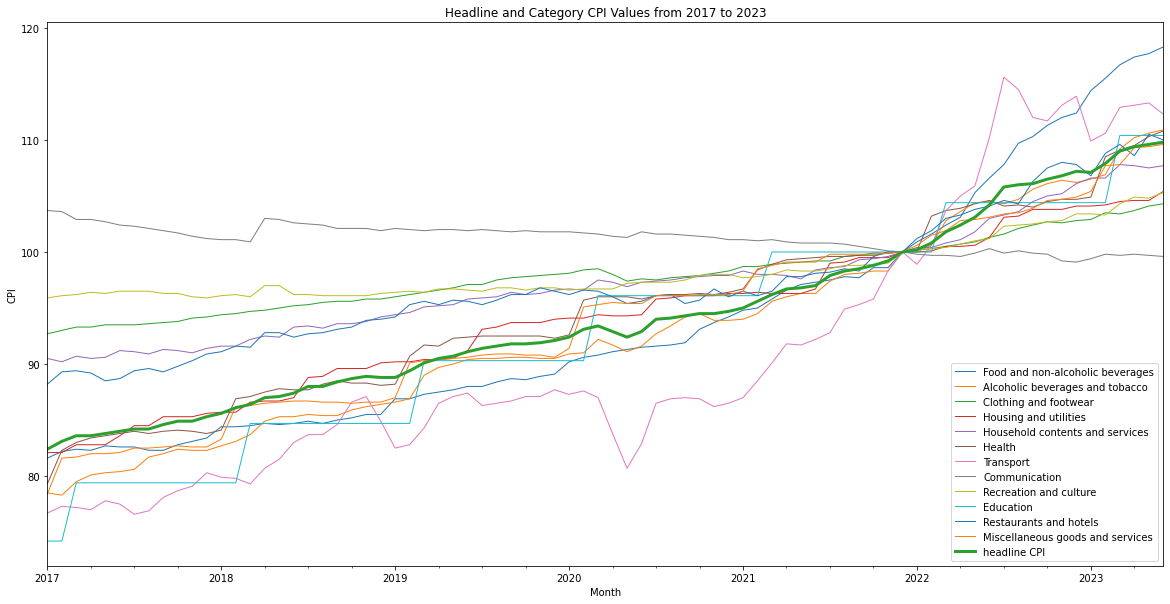

In [26]:
# Plot the data
ax = monthly_cpi_df.plot.line(linewidth=1, figsize=(20,10))  # Set the default linewidth

# Increasing thickness of a specific line.
ax.lines[12].set_linewidth(3)

# Modify the legend labels
handles, labels = ax.get_legend_handles_labels()
new_labels = [category_dict.get(label, label) for label in labels]
plt.legend(handles, new_labels)

# Adding labels and title
plt.xlabel('Month')
plt.ylabel('CPI')
plt.title('Headline and Category CPI Values from 2017 to 2023')

# Displaying the graph
plt.show()

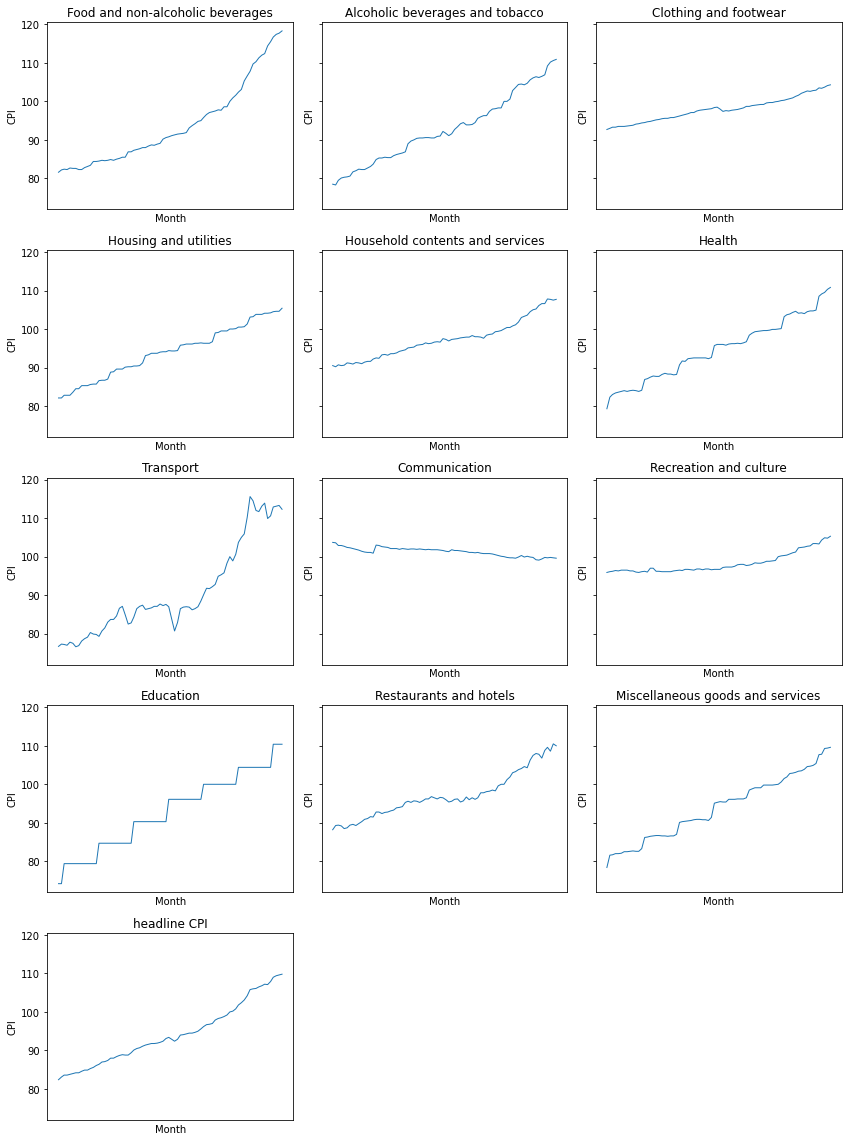

In [27]:
# Plot each category separately to see which categories show the most change over time.
# Determine the number of rows and columns for the grid
n_rows = 5
n_cols = 3

# Create the subplots
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(12, 16), sharey=True)

# Iterate over each series and plot on the subplots
for i, column in enumerate(transposed_cpi_df.columns):
    row = i // n_cols
    col = i % n_cols
    ax = axes[row, col]
    ax.plot(monthly_cpi_df.index, monthly_cpi_df[column], linewidth=1)
    ax.set_title(category_dict.get(column, column))
    ax.set_xlabel('Month')
    ax.set_ylabel('CPI')
    ax.set_xticks([]) 

# Remove unused subplots
for i in range(n_rows * n_cols, len(monthly_cpi_df.columns)):
    fig.delaxes(axes.flatten()[i])

# Adjust spacing between subplots and remove unused subplots
plt.tight_layout()
fig.delaxes(axes[4, 1])
fig.delaxes(axes[4, 2])

## Review Categories Individualy
Fit an ARIMA to each category and forecast new CPI values.

Determine if the forecasted values can be improved by importing additional data and fitting a VAR or VARIMA model.

### Create functions to review the times series and find the best model

In [28]:
# Function to plot the seasonal decomposition graphs
def plotseasonal(res, axes, title):
    res.observed.plot(ax=axes[0], legend=False, title=title)
    axes[0].set_ylabel('Observed')
    res.trend.plot(ax=axes[1], legend=False)
    axes[1].set_ylabel('Trend')
    res.seasonal.plot(ax=axes[2], legend=False)
    axes[2].set_ylabel('Seasonal')
    res.resid.plot(ax=axes[3], legend=False)
    axes[3].set_ylabel('Residual')

In [29]:
# Seasonal Decomposition of the time series
def seasonal_decomposition(df):
    # Multiplicative Decomposition 
    result_mul = seasonal_decompose(df, model='multiplicative', extrapolate_trend='freq')

    # Additive Decomposition
    result_add = seasonal_decompose(df, model='additive', extrapolate_trend='freq')

    fig, axes = plt.subplots(ncols=2, nrows=4, sharex=True, figsize=(12,6))
    plotseasonal(result_mul, axes[:,0], 'Multiplicative Decompose')
    plotseasonal(result_add, axes[:,1], 'Additive Decompose')

    plt.tight_layout()
    plt.show()

In [30]:
def adf_test(series, signif=0.05):
    
    for i in range(4):
        r = adfuller(series, autolag='AIC')
        p_value = round(r[1], 4)
        
        if p_value <= signif:
            print('\n')
            print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
            print(f" => Series is Stationary.")
            print(f" => Differencing factor: d={i}")
            series.plot.line(linewidth=1, figsize=(5,2))
            plt.show()
            break
        if p_value > signif:
            print(f" => Series is not Stationary at d={i}, P-Value={p_value}")
            series.plot.line(linewidth=1, figsize=(5,2))
            plt.show()
            series = series.diff().dropna()
            continue
    
    return i         

In [31]:
def plot_acf_and_pacf(series, diff_factor):
    # Plot ACF and PACF graphs for the original and differenced time series
    plt.rcParams.update({'figure.figsize':(12,5), 'figure.dpi':120})

    # Original Series
    fig, axes = plt.subplots(diff_factor+1, 3)
    axes[0, 0].plot(series); axes[0, 0].set_title('Original Series')
    axes[0, 0].set_xticks([]) 
    plot_acf(series, ax=axes[0, 1])
    axes[0, 1].set_xticks([]) 
    plot_pacf(series, lags=((len(series)/2)-1), ax=axes[0, 2])
    axes[0, 2].set_xticks([]) 

    # 1st Differencing
    for i in range(1,diff_factor+1):
        series = series.diff().dropna()
        if i != diff_factor:
            axes[i, 0].plot(series); axes[1, 0].set_title(f'{i} Order Differencing')
            axes[i, 0].set_xticks([]) 
            plot_acf(series, ax=axes[1, 1])
            axes[i, 1].set_xticks([]) 
            plot_pacf(series, lags=((len(series)/2)-2), ax=axes[i, 2])
            axes[i, 2].set_xticks([]) 
        
        if i == diff_factor:
            axes[i, 0].plot(series); axes[i, 0].set_title(f'{i} Order Differencing')
            axes[i, 0].tick_params(axis='x', labelrotation=45)
            plot_acf(series, ax=axes[i, 1])
            plot_pacf(series, lags=((len(series)/2)-3), ax=axes[i, 2])

    plt.tight_layout()
    plt.show()

In [32]:
def timeseries_eda(dataframe, column_name):
    # Review each category individually
    cat_cpi = dataframe.loc[:, [column_name]].copy()
    
    # Decompose time series
    print('SEASONAL DECOMPOSITION')
    seasonal_decomposition(cat_cpi)
    
    # Determine if a time series a stationary. If not stationary determine the difference factor to make the time
    # series stationary.
    print('\n')
    print('STATIONARITY CHECK')
    diff_factor = adf_test(cat_cpi, signif=0.05)
    
    # Plot the ACF and PACF for the original and differenced time series.
    print('\n')
    print('PLOT ACF AND PACF GRAPHS')
    plot_acf_and_pacf(cat_cpi, diff_factor=diff_factor)

In [33]:
def find_best_model(train_series, test_series, colname):
    # Determine the number of seasonal differences using a Canova-Hansen test
    seasonal_diff = nsdiffs(train_series,
            m=12,  # commonly requires knowledge of dataset
            max_D=12,
            test='ch')  # -> 0
    print(seasonal_diff)
    
    # Fit the auto_arima model and find the best model
    model = pm.auto_arima(train_series, 
                      start_p=1, 
                      start_q=1,
                      test='adf',        # use adftest to find optimal 'd'
                      max_p=3, max_q=3,  # maximum p and q
                      m=12,              # frequency of series
                      d=None,            # let model determine 'd'
                      seasonal=True,     # Seasonality
                      start_P=1, 
                      D=seasonal_diff,
                      start_Q=1,
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

    print(model.summary()) 
    
    # Fit the model
    model.fit(train_series)
    
    # Forecast and compare with the test value
    forecast=model.predict(n_periods=2, return_conf_int=True)
    forecast_df = pd.DataFrame(forecast[0], index=arima_test['01'].index,columns=['Prediction'])
    
    cpi_test_dict[colname] = [forecast_df.index.astype(str)[-1:].item(), 
                              forecast_df[-1:]['Prediction'].item()]
    
    rmse = np.mean((forecast_df['Prediction'] - test_series)**2)**.5  # RMSE
    print('\n')
    print(f'RMSE: {rmse}')
    
    # Plot the train, test and predicted values
    ax = pd.concat([train_series, test_series, forecast_df], axis=1).plot(figsize=(8,4))

    # Modify the legend labels
    handles, labels = ax.get_legend_handles_labels()
    plt.legend(handles, ['train', 'test', 'prediction'])
    plt.show()
    
    return model

In [34]:
def forecast_unseen_values(dataframe, colname, model, periods_to_predict, forecast_start_date):
    model.fit(dataframe[colname])
    
    forecast_unseen=model.predict(n_periods=periods_to_predict, return_conf_int=True)
    
    forecast_range=pd.date_range(start=forecast_start_date, periods=periods_to_predict, freq='M')
    
    forecast_unseen_df = pd.DataFrame(forecast_unseen[0], index=forecast_unseen[0].index,columns=['Prediction'])
    
    # Add last predicted value to CPI dictionary
    cpi_dict[colname] = [forecast_unseen_df.index.astype(str)[-1:].item(), 
                         forecast_unseen_df[-1:]['Prediction'].item()]
    
    # Plot the new forecasted values
    ax = dataframe[colname].plot(figsize=(8,4))
    forecast_unseen_df.plot(ax=ax, marker='o', markersize=3)

    # Modify the legend labels
    handles, labels = ax.get_legend_handles_labels()
    plt.legend(handles, ['actual', 'prediction'])
    plt.show()
    
    return forecast_unseen_df

### Create train and test data sets and a dictionary to store the predicted CPI values

In [35]:
# Create a dictionary where the predicted CPI for each category will be stored.
cpi_test_dict={}
cpi_dict={}

In [36]:
# monthly_cpi_df
reduced_monthly_cpi = monthly_cpi_df.drop(index=monthly_cpi_df.index[:36]).copy()
# v17: 24
# v18: 36

In [37]:
def create_test_and_train(df, len_test_df):
    # Split train and test
    train = df.iloc[:-len_test_df]
    test = df.iloc[-len_test_df:]
        
    return train, test

In [38]:
arima_train, arima_test = create_test_and_train(reduced_monthly_cpi, len_test_df=2)

### Category 1: Food and non-alcoholic beverages
##### Review the time series

SEASONAL DECOMPOSITION


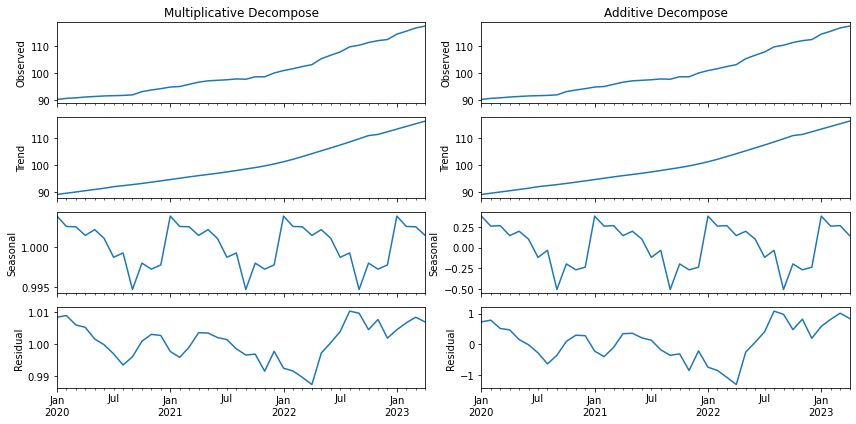



STATIONARITY CHECK
 => Series is not Stationary at d=0, P-Value=1.0


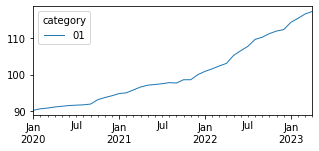

 => Series is not Stationary at d=1, P-Value=0.5845


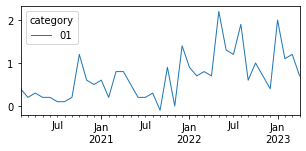



 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.
 => Differencing factor: d=2


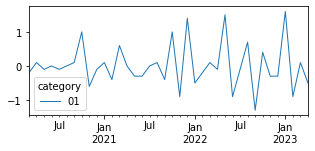



PLOT ACF AND PACF GRAPHS


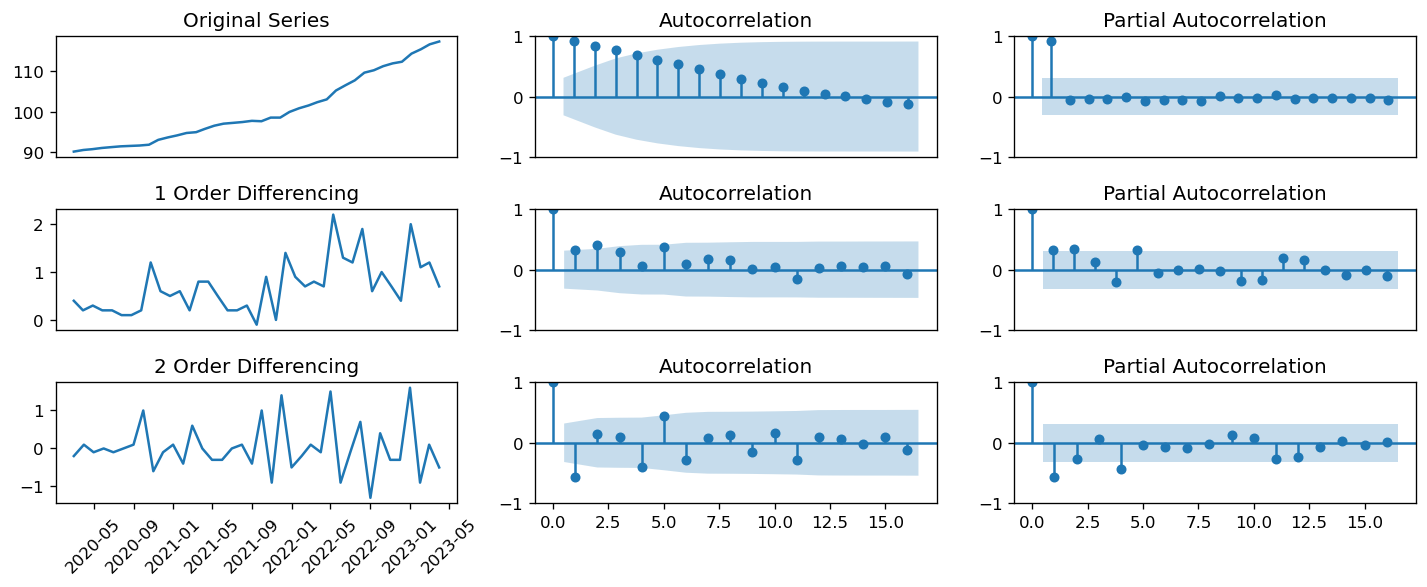

In [39]:
timeseries_eda(arima_train, '01')

##### ARIMA
Use auto_arima to find the best model.

0
Performing stepwise search to minimize aic
 ARIMA(1,2,1)(1,0,1)[12]             : AIC=inf, Time=0.19 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=76.080, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=65.148, Time=0.04 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=60.805, Time=0.05 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=59.028, Time=0.03 sec
 ARIMA(0,2,1)(1,0,0)[12]             : AIC=60.845, Time=0.07 sec
 ARIMA(0,2,1)(1,0,1)[12]             : AIC=inf, Time=0.31 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=60.723, Time=0.03 sec
 ARIMA(0,2,2)(0,0,0)[12]             : AIC=60.815, Time=0.03 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=63.239, Time=0.02 sec
 ARIMA(1,2,2)(0,0,0)[12]             : AIC=inf, Time=0.13 sec
 ARIMA(0,2,1)(0,0,0)[12] intercept   : AIC=inf, Time=0.07 sec

Best model:  ARIMA(0,2,1)(0,0,0)[12]          
Total fit time: 0.996 seconds
                               SARIMAX Results                                
Dep. Variable:                

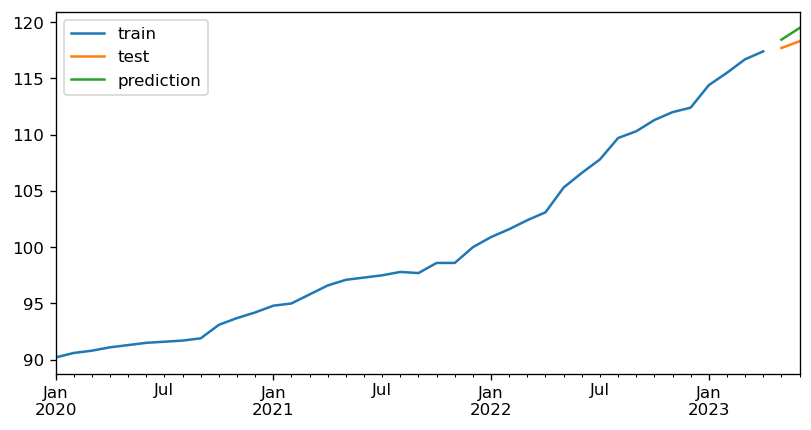

In [40]:
cat_model = find_best_model(arima_train['01'], arima_test['01'], colname='01')

##### Forecast the new CPI values

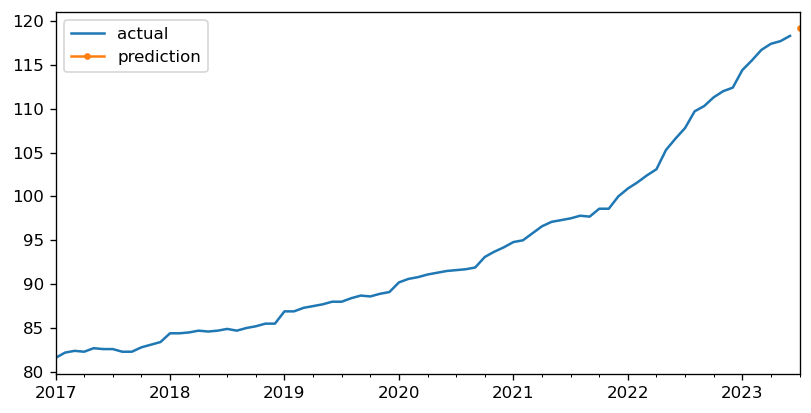

In [41]:
unseen_forecast = forecast_unseen_values(monthly_cpi_df, colname='01', model=cat_model, periods_to_predict=1, 
                       forecast_start_date='2023-07-01')

In [42]:
unseen_forecast

Prediction
2023-07-01  119.151592

### Category 2: Alcoholic beverages and tobacco
##### Review the time series

SEASONAL DECOMPOSITION


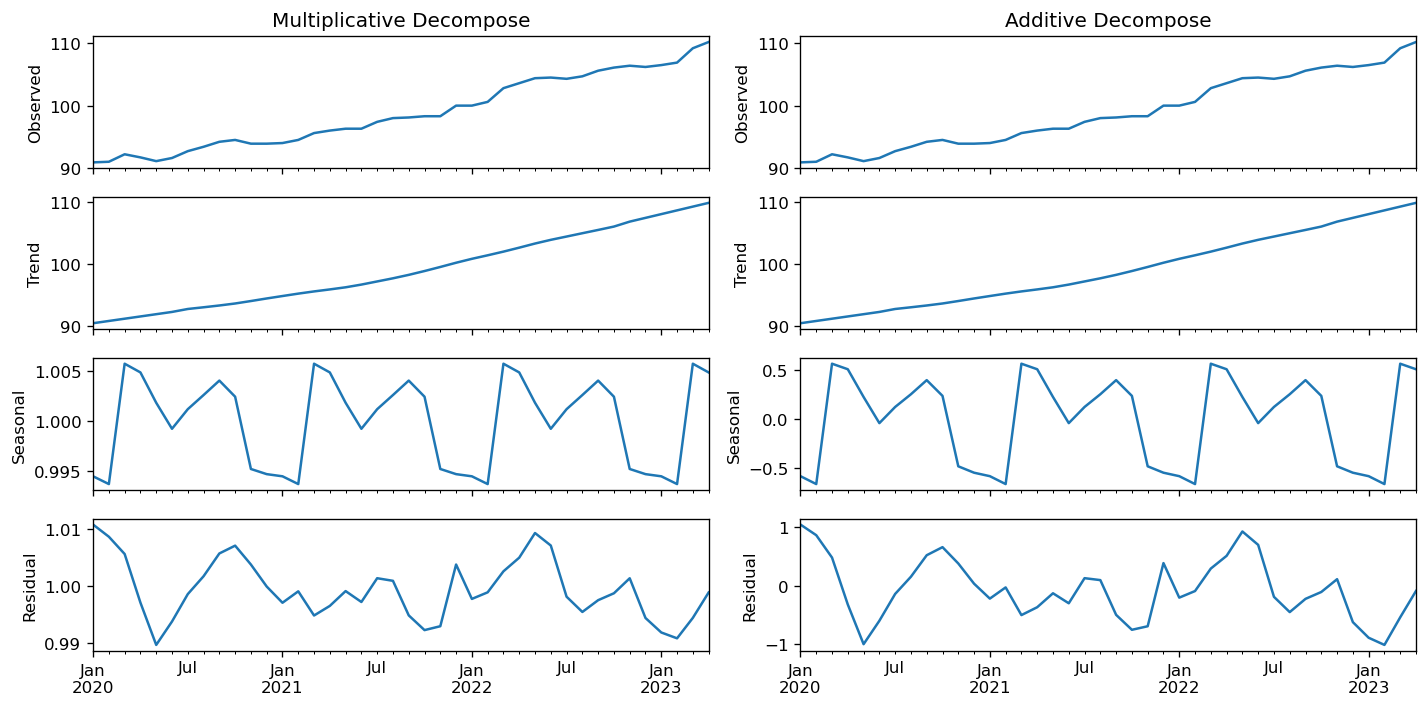



STATIONARITY CHECK
 => Series is not Stationary at d=0, P-Value=0.9952


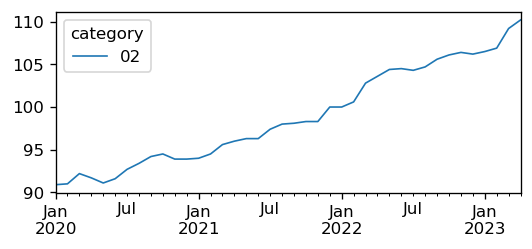



 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.
 => Differencing factor: d=1


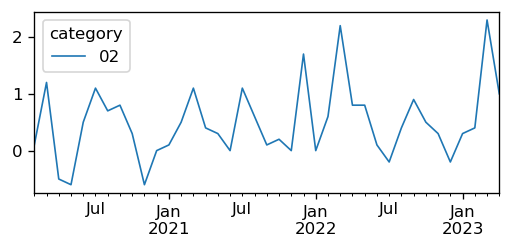



PLOT ACF AND PACF GRAPHS


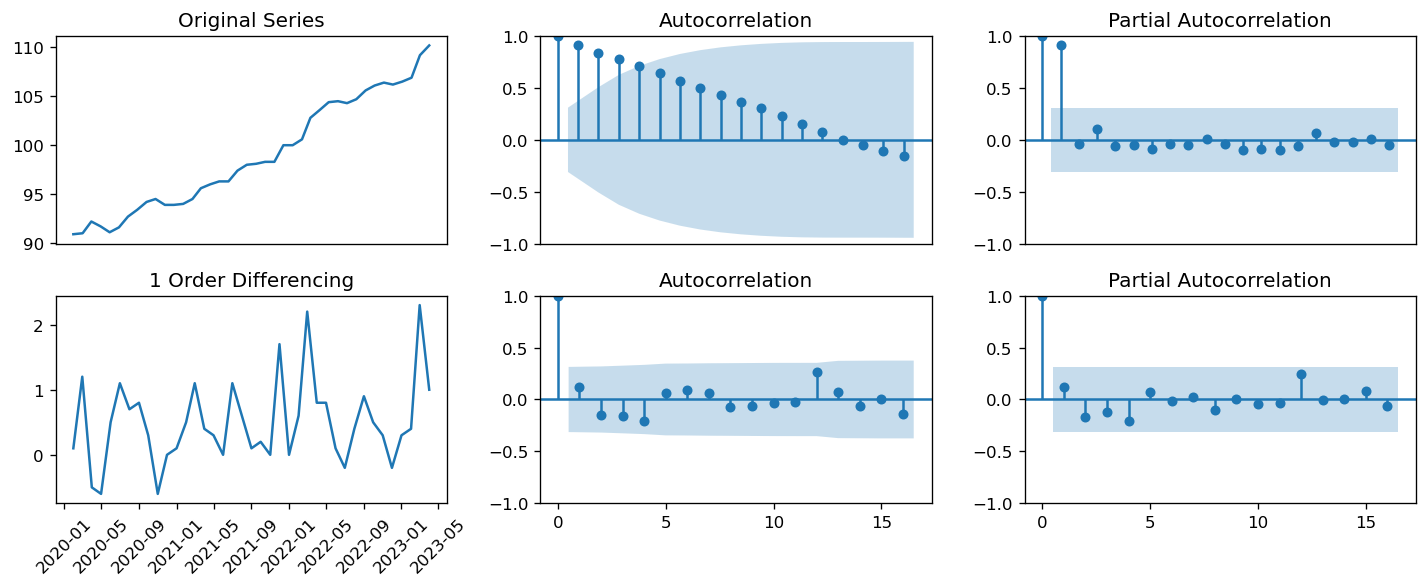

In [43]:
timeseries_eda(arima_train, '02')

##### ARIMA
Use auto_arima to find the best model.

0
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=81.527, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=80.411, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=79.418, Time=0.07 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=80.034, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=96.487, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=81.819, Time=0.03 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=80.855, Time=0.36 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=80.832, Time=0.27 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=80.243, Time=0.07 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=82.832, Time=0.76 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=78.037, Time=0.06 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=79.765, Time=0.22 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=79.775, Time=0.15 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=78.790, Time=0.07 sec
 ARIMA(0,1,0)(2,0,1)[12] intercept   : AIC=81

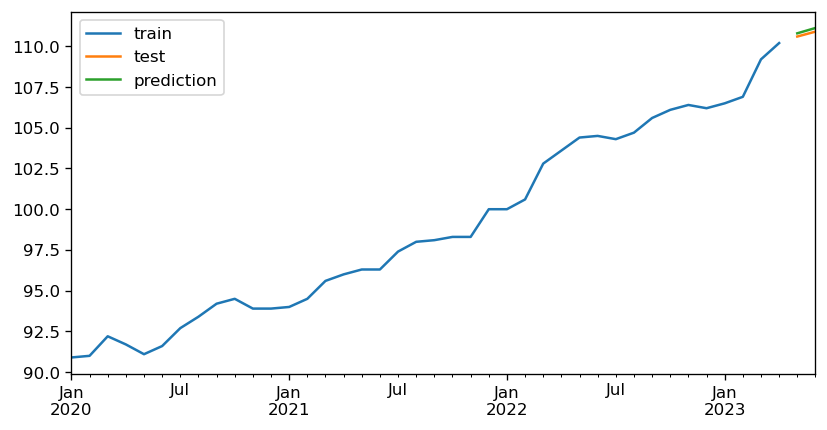

In [44]:
cat_model = find_best_model(arima_train['02'], arima_test['02'], colname='02')

##### Forecast the new CPI values

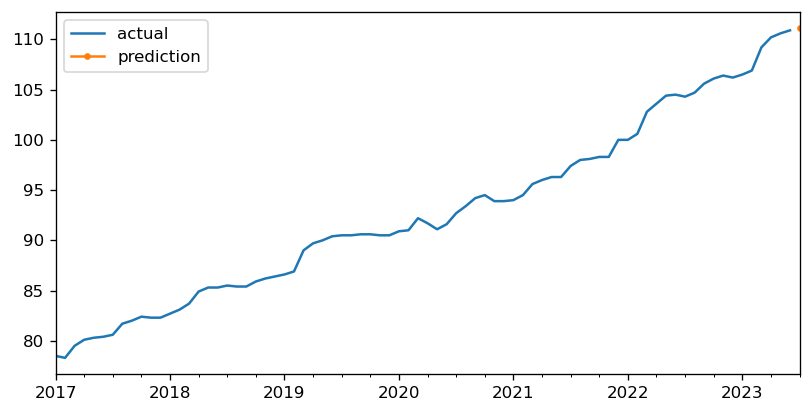

In [45]:
unseen_forecast = forecast_unseen_values(monthly_cpi_df, colname='02', model=cat_model, periods_to_predict=1, 
                       forecast_start_date='2023-07-01')

In [46]:
unseen_forecast

Prediction
2023-07-01  111.093681

### Category 3: Clothing and footwear
##### Review the time series

SEASONAL DECOMPOSITION


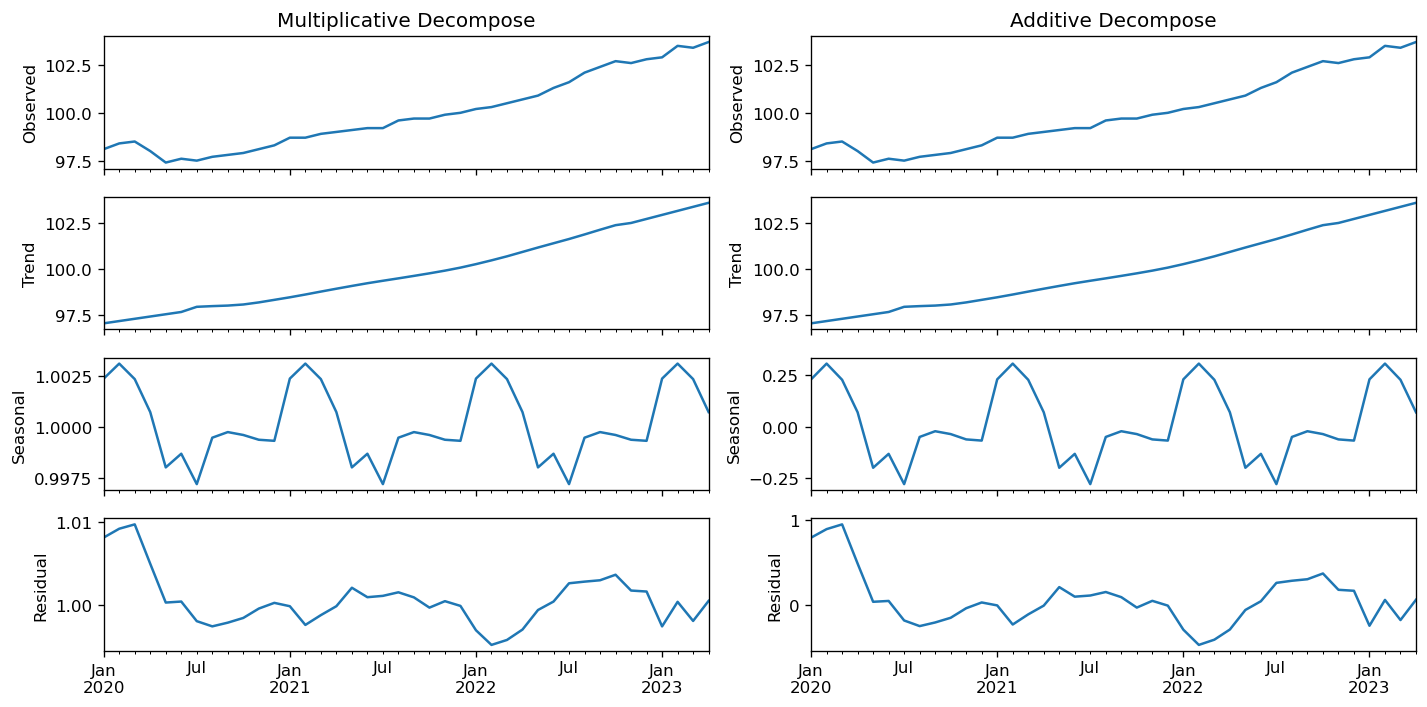



STATIONARITY CHECK
 => Series is not Stationary at d=0, P-Value=0.9983


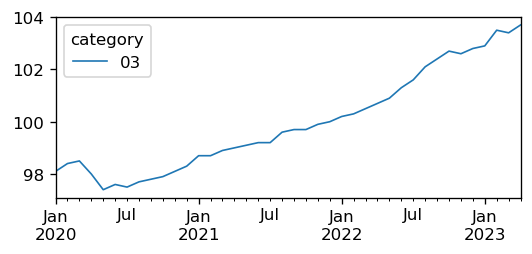



 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.
 => Differencing factor: d=1


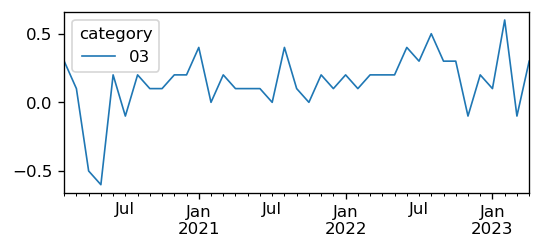



PLOT ACF AND PACF GRAPHS


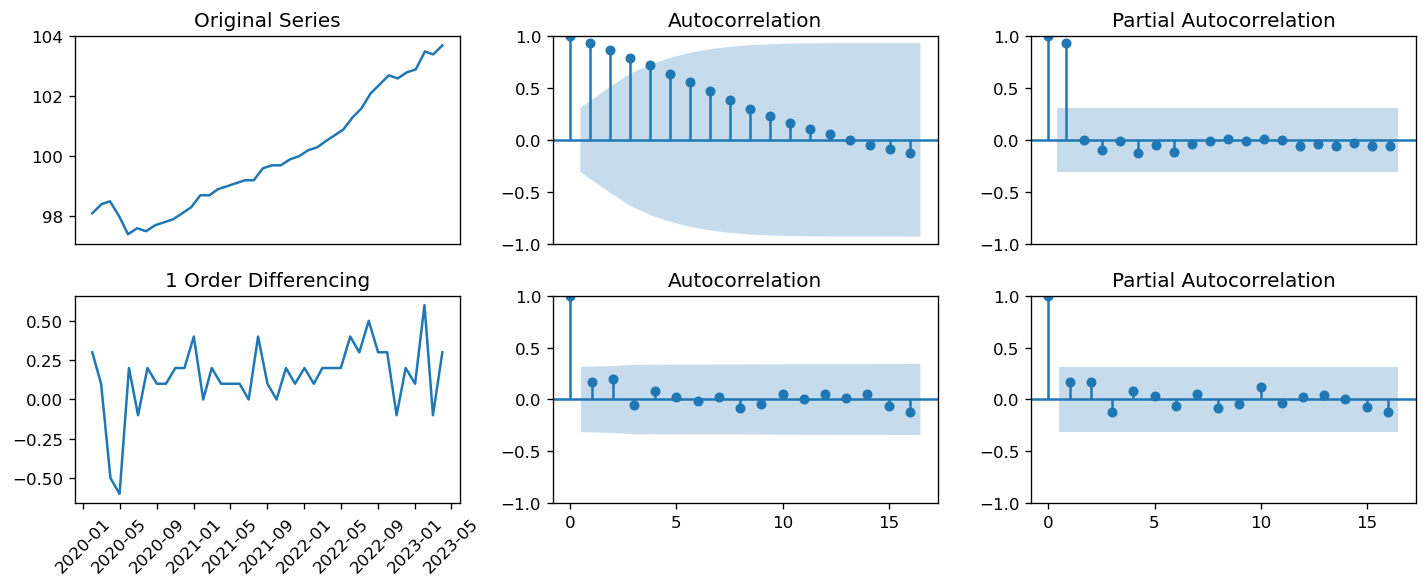

In [47]:
timeseries_eda(arima_train, '03')

##### ARIMA
Use auto_arima to find the best model.

0
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=2.870, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-2.844, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-0.238, Time=0.07 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-0.215, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=8.823, Time=0.03 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-1.094, Time=0.10 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-1.402, Time=0.08 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=0.163, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-1.960, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=-1.652, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=-0.449, Time=0.09 sec

Best model:  ARIMA(0,1,0)(0,0,0)[12] intercept
Total fit time: 0.921 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   40
Model: 

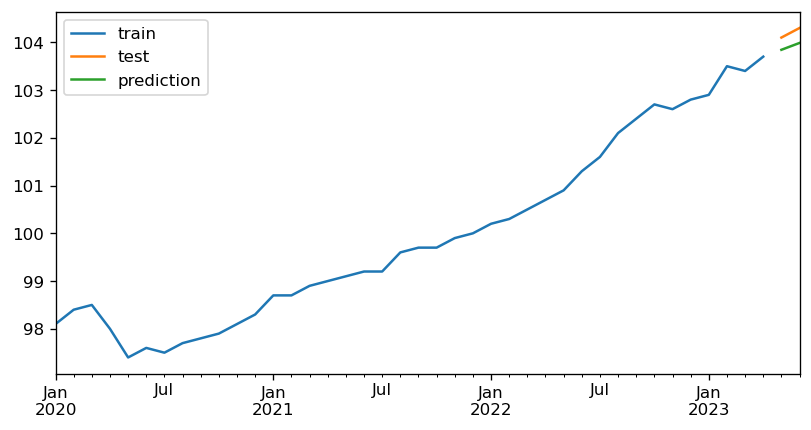

In [48]:
cat_model = find_best_model(arima_train['03'], arima_test['03'], colname='03')

##### Forecast the new CPI values

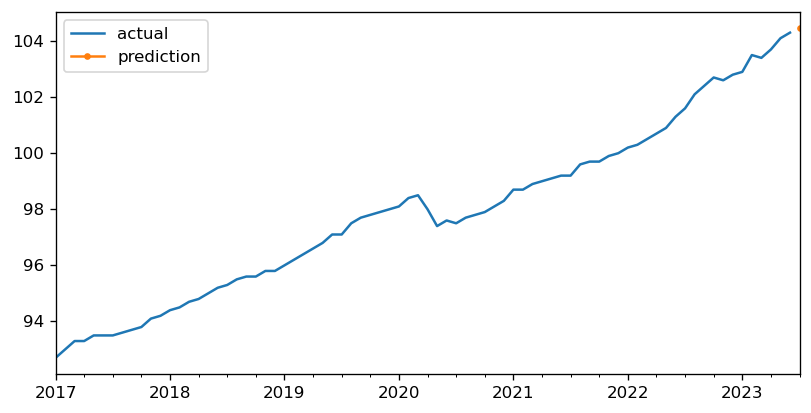

In [49]:
unseen_forecast = forecast_unseen_values(monthly_cpi_df, colname='03', model=cat_model, periods_to_predict=1, 
                       forecast_start_date='2023-07-01')

In [50]:
unseen_forecast

Prediction
2023-07-01  104.450649

### Category 4: Housing and utilities
##### Review the time series

SEASONAL DECOMPOSITION


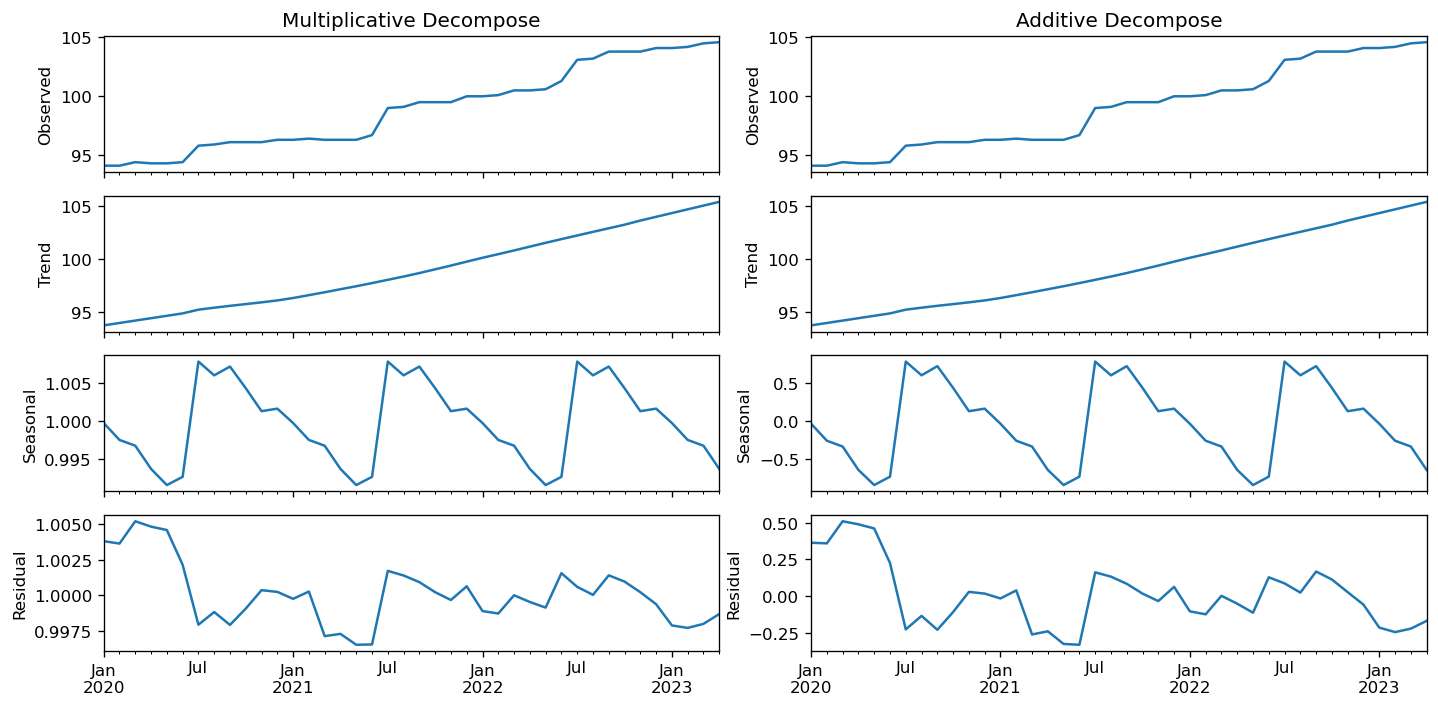



STATIONARITY CHECK
 => Series is not Stationary at d=0, P-Value=0.9519


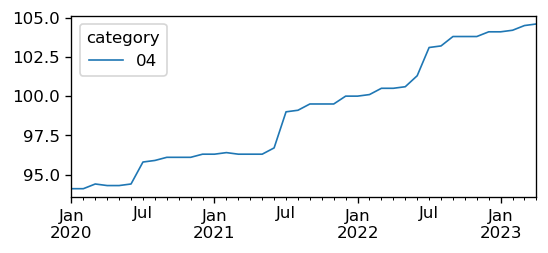



 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.
 => Differencing factor: d=1


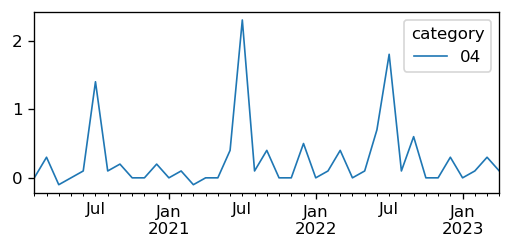



PLOT ACF AND PACF GRAPHS


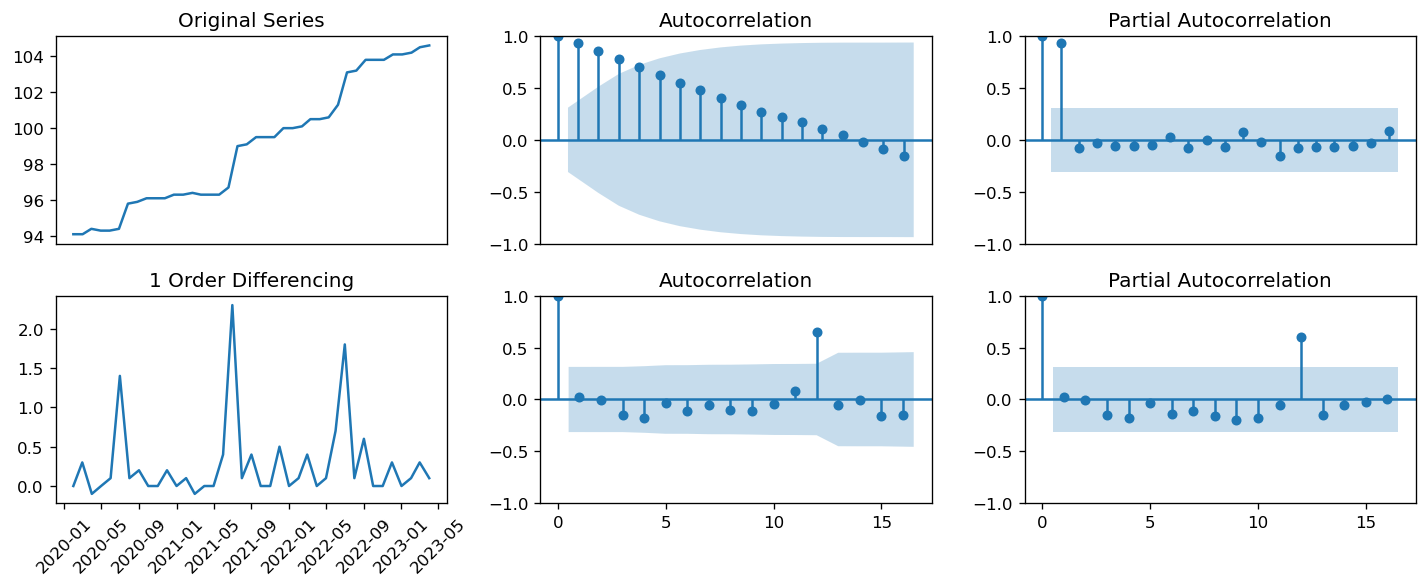

In [51]:
timeseries_eda(arima_train, '04')

##### ARIMA
Use auto_arima to find the best model.

0
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=26.652, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=60.424, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=26.159, Time=0.08 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=68.395, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=62.399, Time=0.03 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=inf, Time=0.44 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=25.270, Time=0.32 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=27.202, Time=0.83 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=inf, Time=0.48 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=inf, Time=0.67 sec
 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=inf, Time=1.08 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=23.684, Time=0.30 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=inf, Time=0.10 sec
 

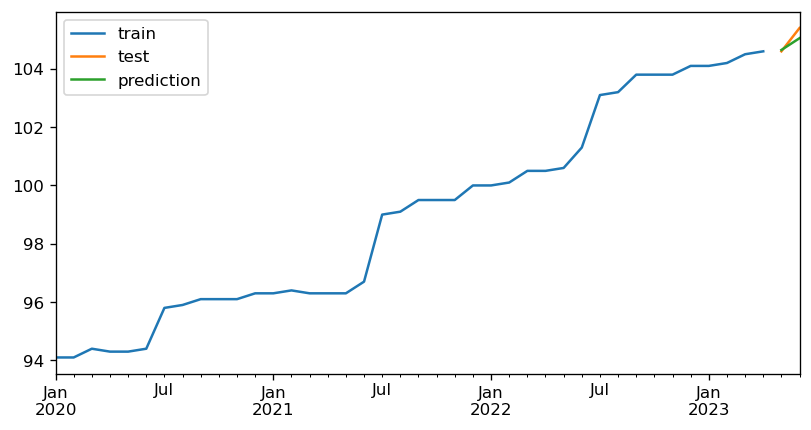

In [52]:
cat_model = find_best_model(arima_train['04'], arima_test['04'], colname='04')

##### Forecast the new CPI values

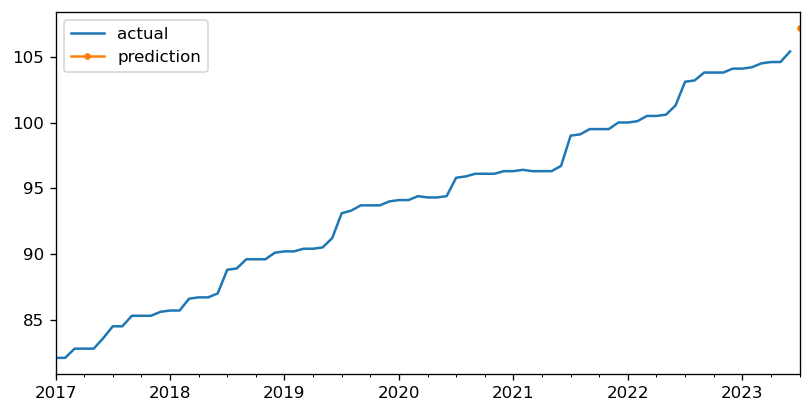

In [53]:
unseen_forecast = forecast_unseen_values(monthly_cpi_df, colname='04', model=cat_model, periods_to_predict=1, 
                       forecast_start_date='2023-07-01')

In [54]:
unseen_forecast

Prediction
2023-07-01  107.157154

### Category 5: Household contents and services
##### Review the time series

SEASONAL DECOMPOSITION


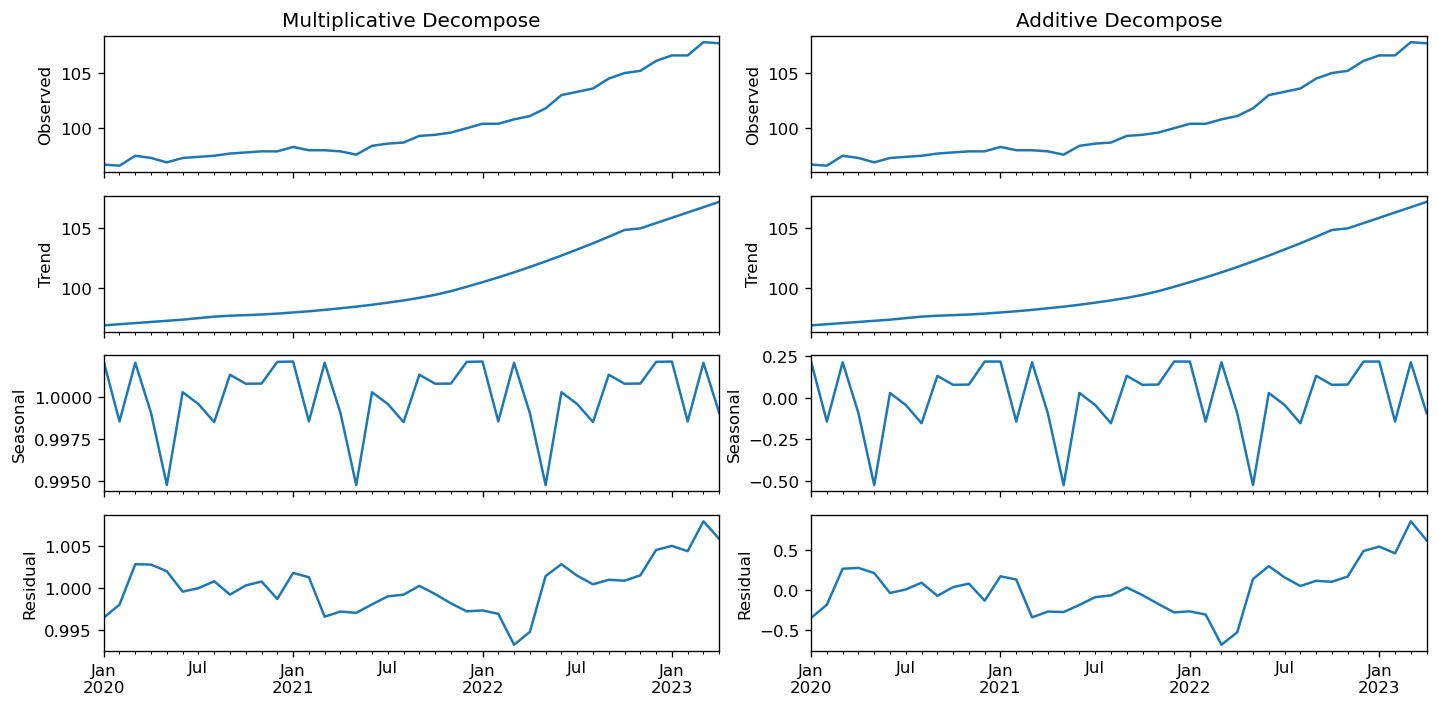



STATIONARITY CHECK
 => Series is not Stationary at d=0, P-Value=0.9956


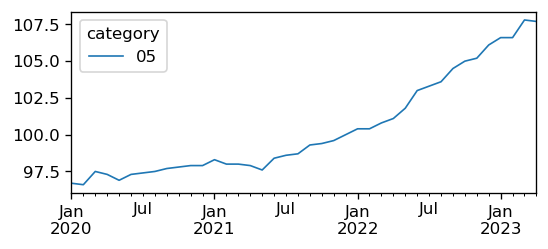

 => Series is not Stationary at d=1, P-Value=0.4665


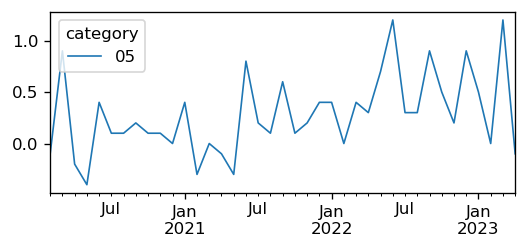



 => P-Value = 0.0493. Rejecting Null Hypothesis.
 => Series is Stationary.
 => Differencing factor: d=2


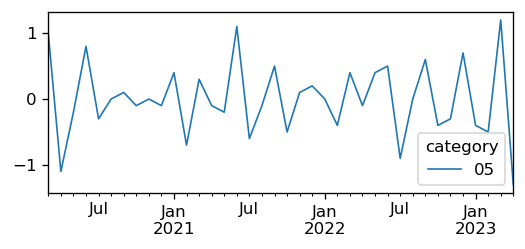



PLOT ACF AND PACF GRAPHS


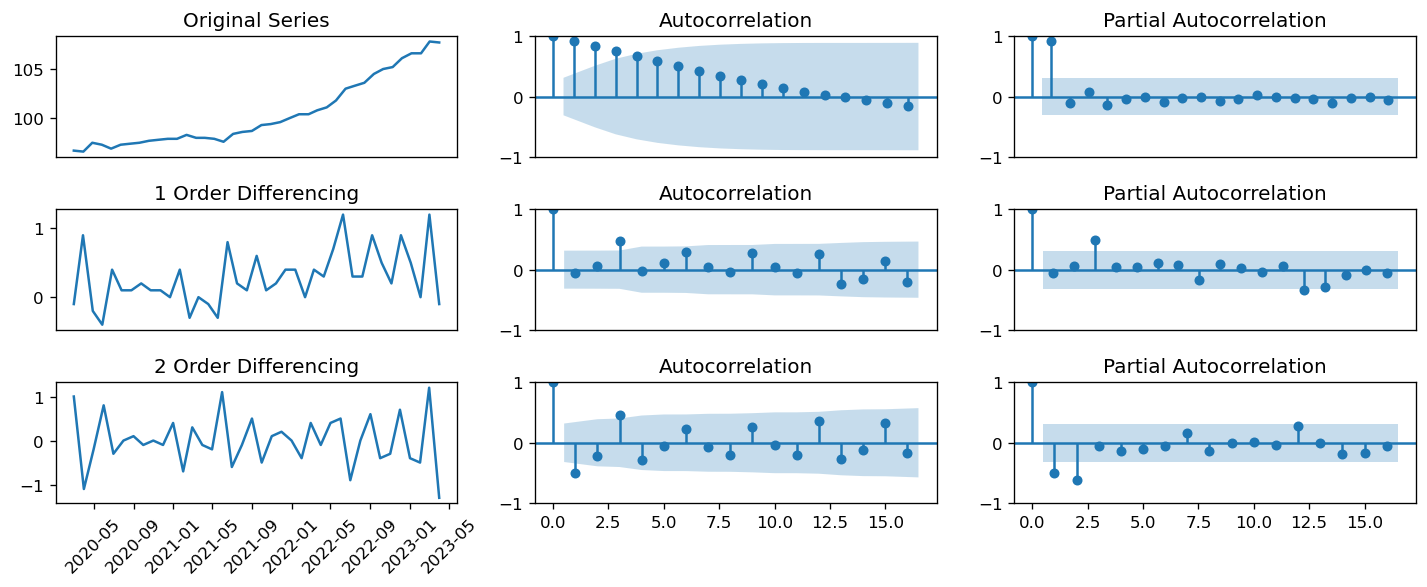

In [55]:
timeseries_eda(arima_train, '05')

##### ARIMA
Use auto_arima to find the best model.

0
Performing stepwise search to minimize aic
 ARIMA(1,2,1)(1,0,1)[12]             : AIC=inf, Time=0.18 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=66.416, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=43.682, Time=0.06 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=inf, Time=0.18 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=54.308, Time=0.04 sec
 ARIMA(1,2,0)(2,0,0)[12]             : AIC=42.710, Time=0.53 sec
 ARIMA(1,2,0)(2,0,1)[12]             : AIC=inf, Time=0.59 sec
 ARIMA(1,2,0)(1,0,1)[12]             : AIC=inf, Time=0.26 sec
 ARIMA(0,2,0)(2,0,0)[12]             : AIC=58.550, Time=0.15 sec
 ARIMA(2,2,0)(2,0,0)[12]             : AIC=31.875, Time=0.44 sec
 ARIMA(2,2,0)(1,0,0)[12]             : AIC=31.555, Time=0.11 sec
 ARIMA(2,2,0)(0,0,0)[12]             : AIC=32.522, Time=0.04 sec
 ARIMA(2,2,0)(1,0,1)[12]             : AIC=inf, Time=0.26 sec
 ARIMA(2,2,0)(0,0,1)[12]             : AIC=inf, Time=0.13 sec
 ARIMA(2,2,0)(2,0,1)[12]             : AIC=inf, Time=1.02 sec
 

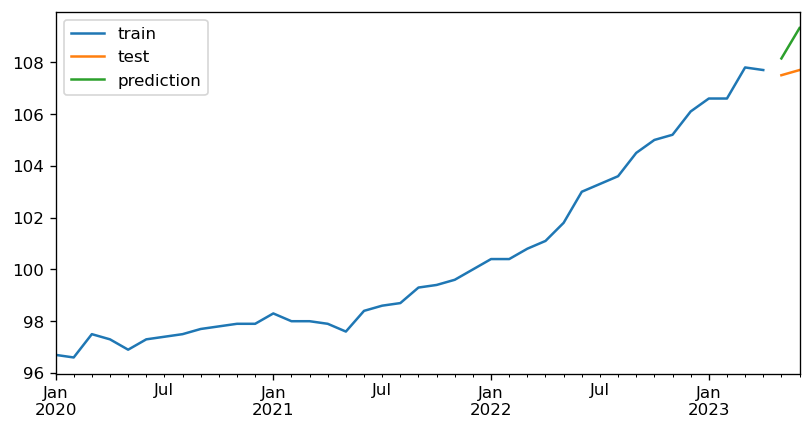

In [56]:
cat_model = find_best_model(arima_train['05'], arima_test['05'], colname='05')

##### Forecast the new CPI values

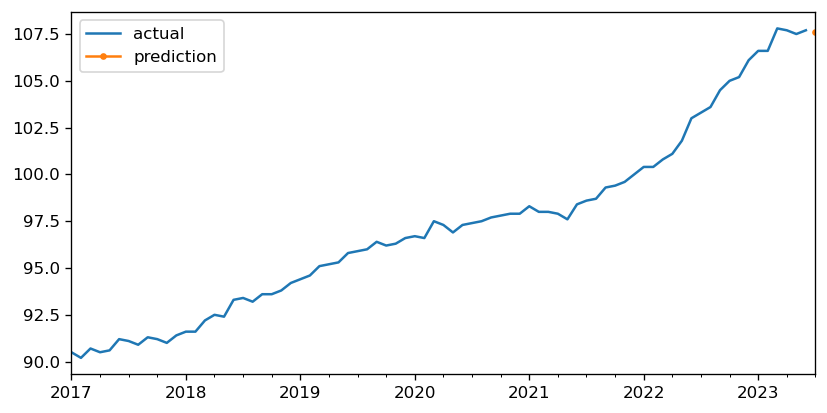

In [57]:
unseen_forecast = forecast_unseen_values(monthly_cpi_df, colname='05', model=cat_model, periods_to_predict=1, 
                       forecast_start_date='2023-07-01')

In [58]:
unseen_forecast

Prediction
2023-07-01   107.58886

### Category 6: Health
##### Review the time series

SEASONAL DECOMPOSITION


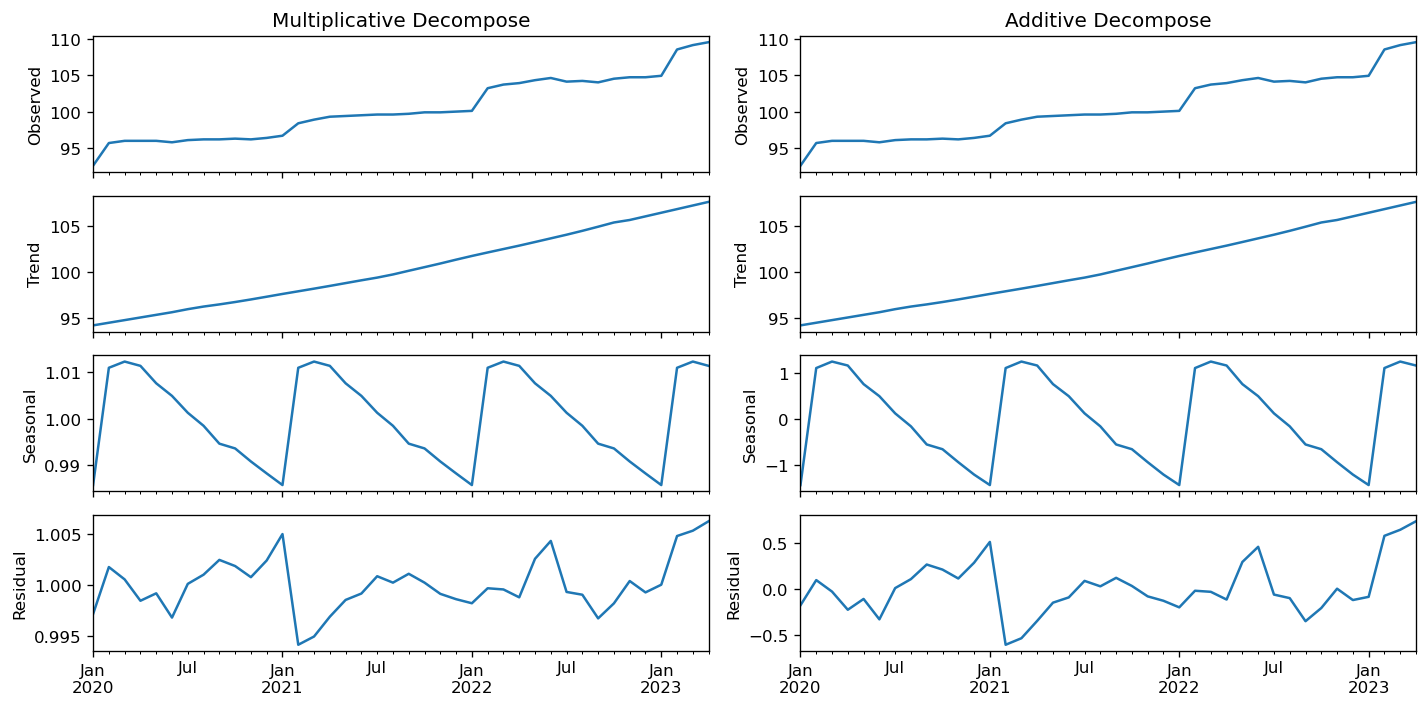



STATIONARITY CHECK
 => Series is not Stationary at d=0, P-Value=0.9988


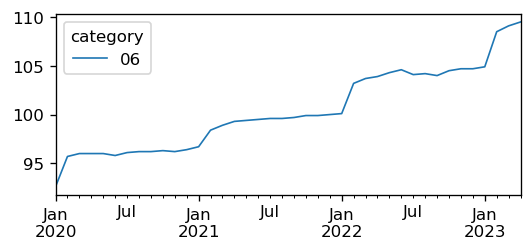



 => P-Value = 0.0002. Rejecting Null Hypothesis.
 => Series is Stationary.
 => Differencing factor: d=1


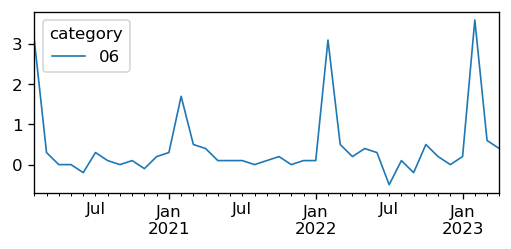



PLOT ACF AND PACF GRAPHS


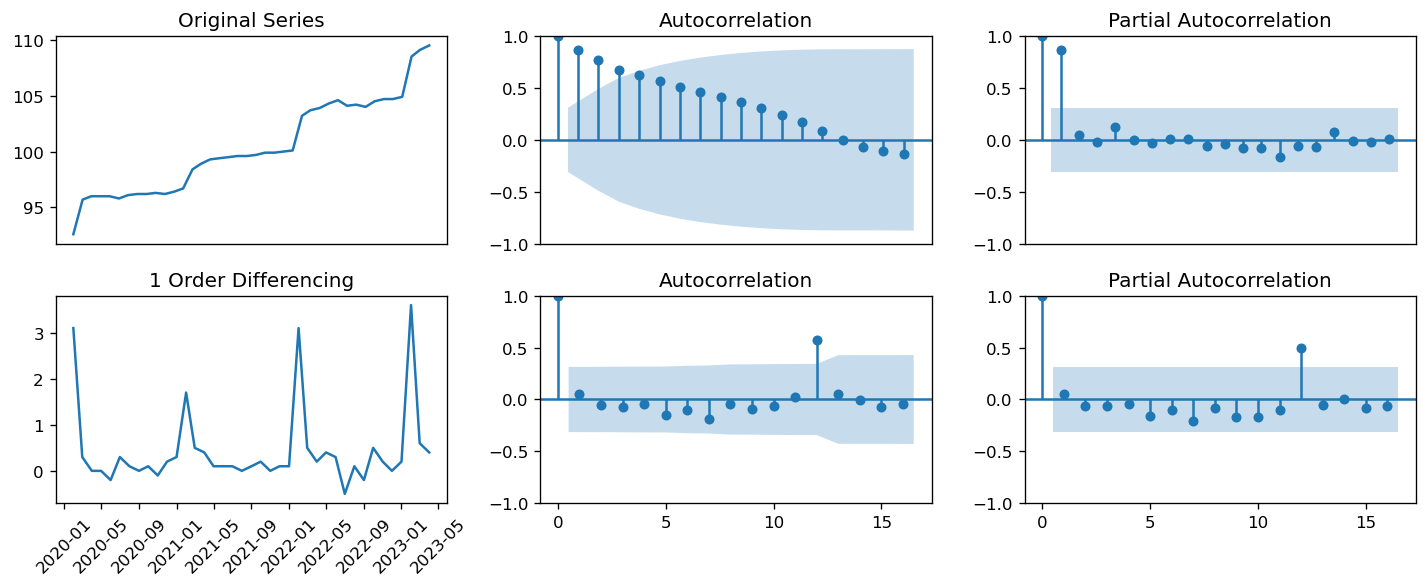

In [59]:
timeseries_eda(arima_train, '06')

##### ARIMA
Use auto_arima to find the best model.

0
Performing stepwise search to minimize aic
 ARIMA(1,2,1)(1,0,1)[12]             : AIC=69.614, Time=0.15 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=120.457, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=84.892, Time=0.06 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=inf, Time=0.09 sec
 ARIMA(1,2,1)(0,0,1)[12]             : AIC=inf, Time=0.26 sec
 ARIMA(1,2,1)(1,0,0)[12]             : AIC=inf, Time=0.18 sec
 ARIMA(1,2,1)(2,0,1)[12]             : AIC=inf, Time=0.75 sec
 ARIMA(1,2,1)(1,0,2)[12]             : AIC=inf, Time=0.96 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=inf, Time=0.10 sec
 ARIMA(1,2,1)(0,0,2)[12]             : AIC=inf, Time=0.63 sec
 ARIMA(1,2,1)(2,0,0)[12]             : AIC=inf, Time=0.57 sec
 ARIMA(1,2,1)(2,0,2)[12]             : AIC=inf, Time=1.31 sec
 ARIMA(0,2,1)(1,0,1)[12]             : AIC=67.579, Time=0.29 sec
 ARIMA(0,2,1)(1,0,0)[12]             : AIC=inf, Time=0.11 sec
 ARIMA(0,2,1)(2,0,1)[12]             : AIC=inf, Time=0.83 sec
 ARIMA(0,2,1

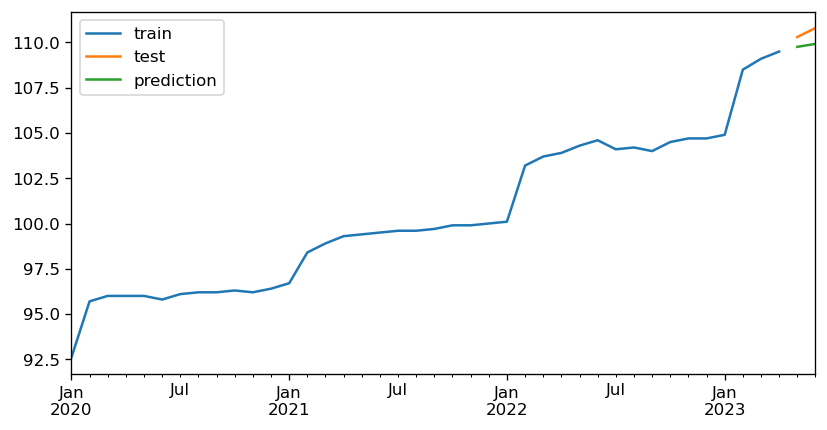

In [60]:
cat_model = find_best_model(arima_train['06'], arima_test['06'], colname='06')

##### Forecast the new CPI values

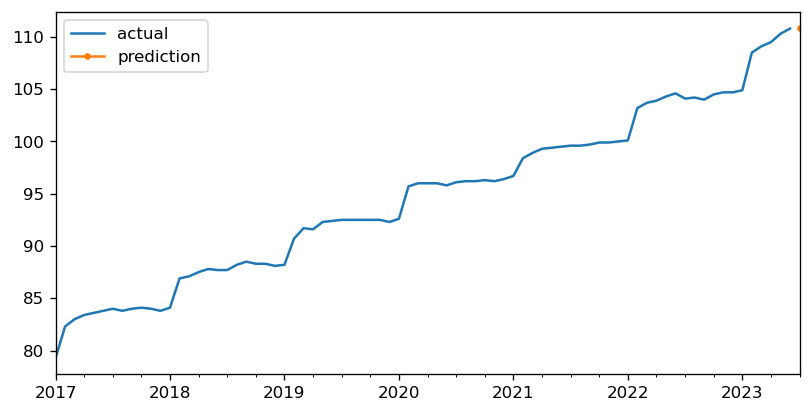

In [61]:
unseen_forecast = forecast_unseen_values(monthly_cpi_df, colname='06', model=cat_model, periods_to_predict=1, 
                       forecast_start_date='2023-07-01')

In [62]:
unseen_forecast

Prediction
2023-07-01  110.814572

### Category 7: Transport
##### Review the time series

SEASONAL DECOMPOSITION


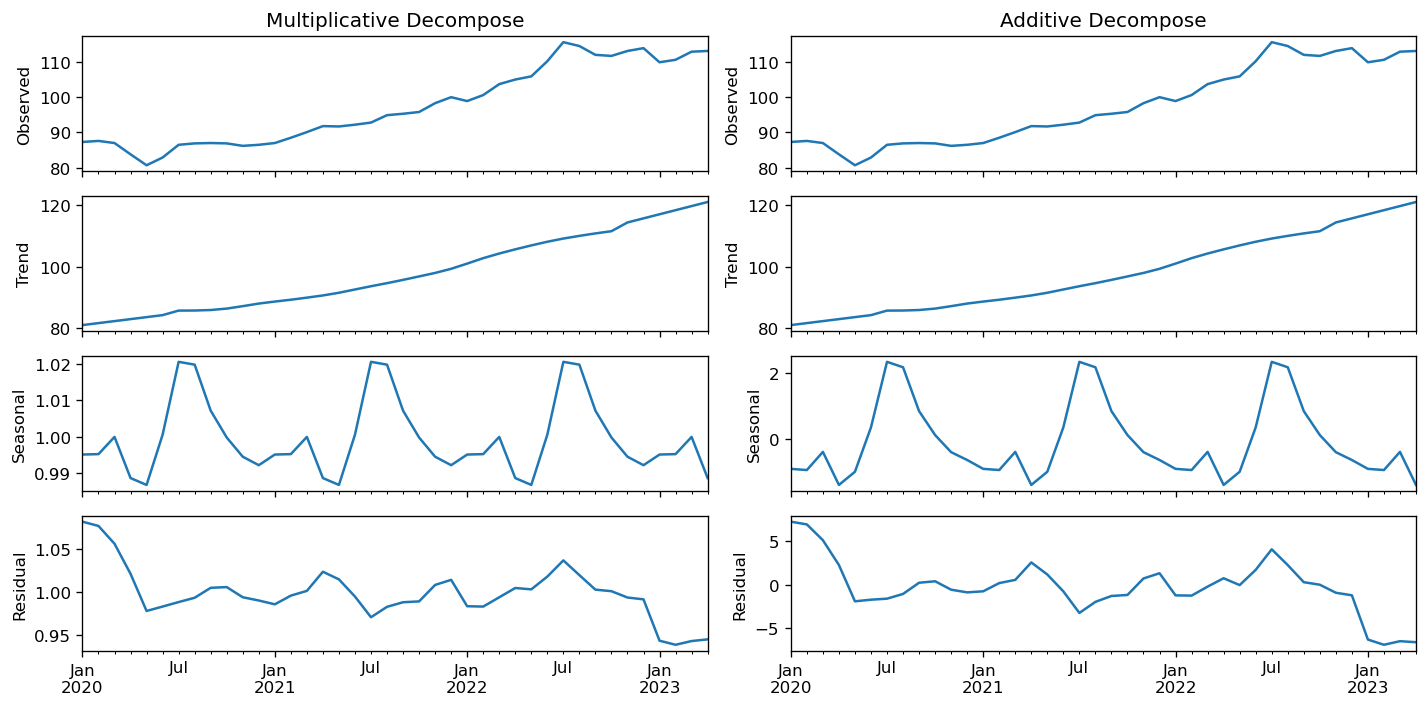



STATIONARITY CHECK
 => Series is not Stationary at d=0, P-Value=0.8672


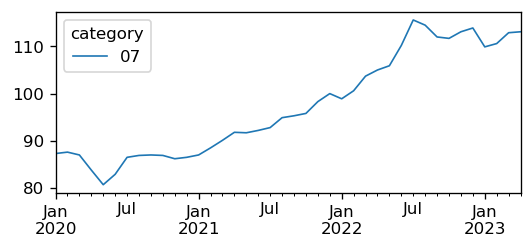



 => P-Value = 0.0102. Rejecting Null Hypothesis.
 => Series is Stationary.
 => Differencing factor: d=1


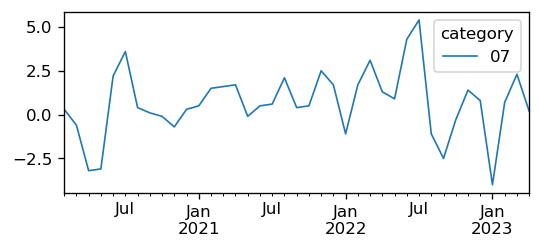



PLOT ACF AND PACF GRAPHS


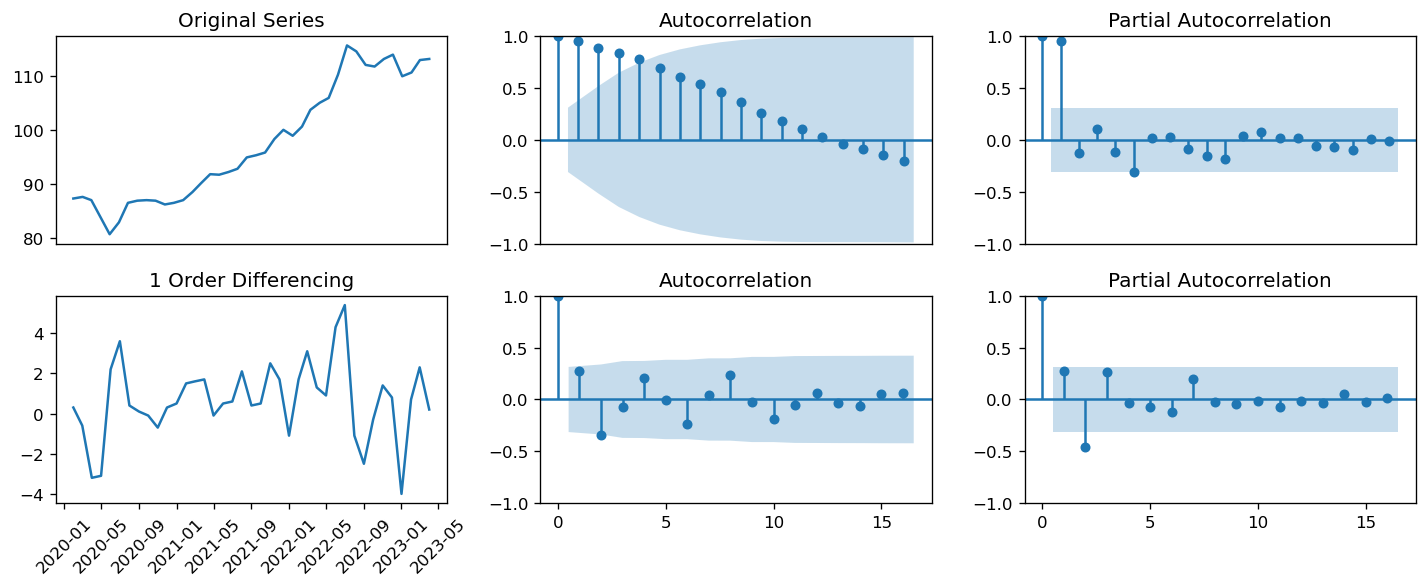

In [63]:
timeseries_eda(arima_train, '07')

##### ARIMA
Use auto_arima to find the best model.

0
Performing stepwise search to minimize aic
 ARIMA(1,2,1)(1,0,1)[12]             : AIC=inf, Time=0.18 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=173.331, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=175.280, Time=0.04 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=166.642, Time=0.06 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=165.054, Time=0.02 sec
 ARIMA(0,2,1)(1,0,0)[12]             : AIC=166.373, Time=0.04 sec
 ARIMA(0,2,1)(1,0,1)[12]             : AIC=inf, Time=0.30 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=inf, Time=0.09 sec
 ARIMA(0,2,2)(0,0,0)[12]             : AIC=inf, Time=0.11 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=175.158, Time=0.02 sec
 ARIMA(1,2,2)(0,0,0)[12]             : AIC=inf, Time=0.09 sec
 ARIMA(0,2,1)(0,0,0)[12] intercept   : AIC=inf, Time=0.05 sec

Best model:  ARIMA(0,2,1)(0,0,0)[12]          
Total fit time: 1.021 seconds
                               SARIMAX Results                                
Dep. Variable:                

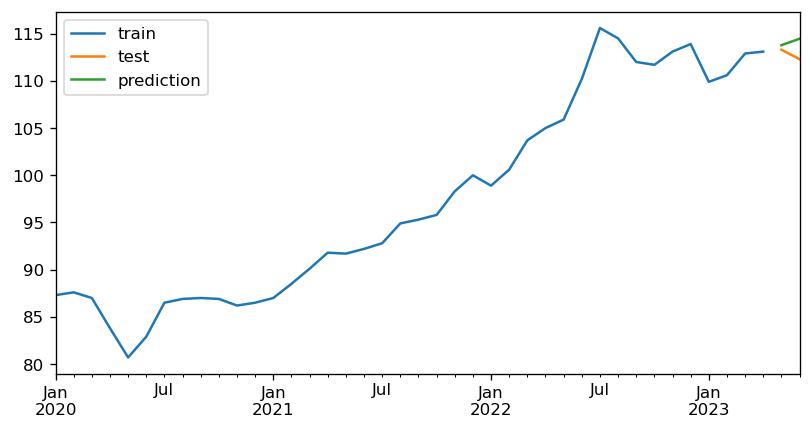

In [64]:
cat_model = find_best_model(arima_train['07'], arima_test['07'], colname='07')

##### Forecast the new CPI values

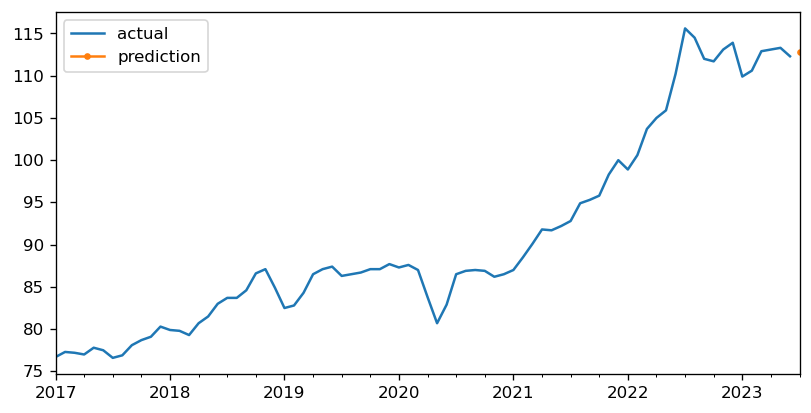

In [65]:
unseen_forecast = forecast_unseen_values(monthly_cpi_df, colname='07', model=cat_model, periods_to_predict=1, 
                       forecast_start_date='2023-07-01')

In [66]:
unseen_forecast

Prediction
2023-07-01  112.815944

### Category 8: Communication
##### Review the time series

SEASONAL DECOMPOSITION


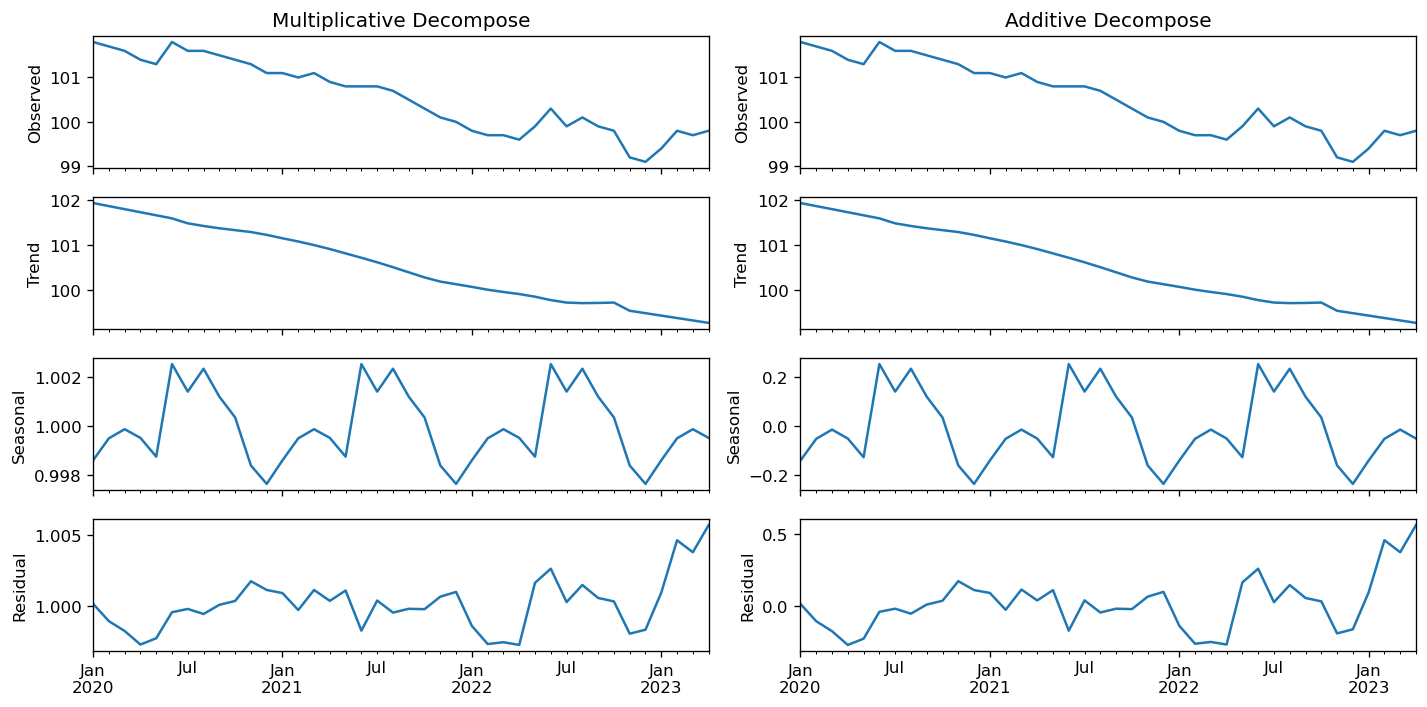



STATIONARITY CHECK
 => Series is not Stationary at d=0, P-Value=0.622


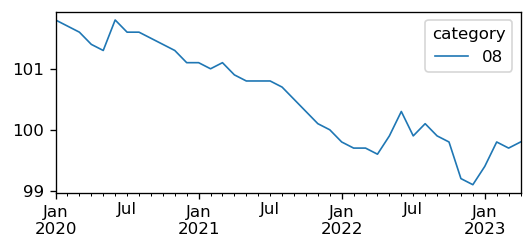



 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.
 => Differencing factor: d=1


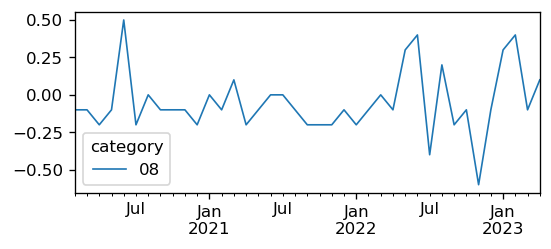



PLOT ACF AND PACF GRAPHS


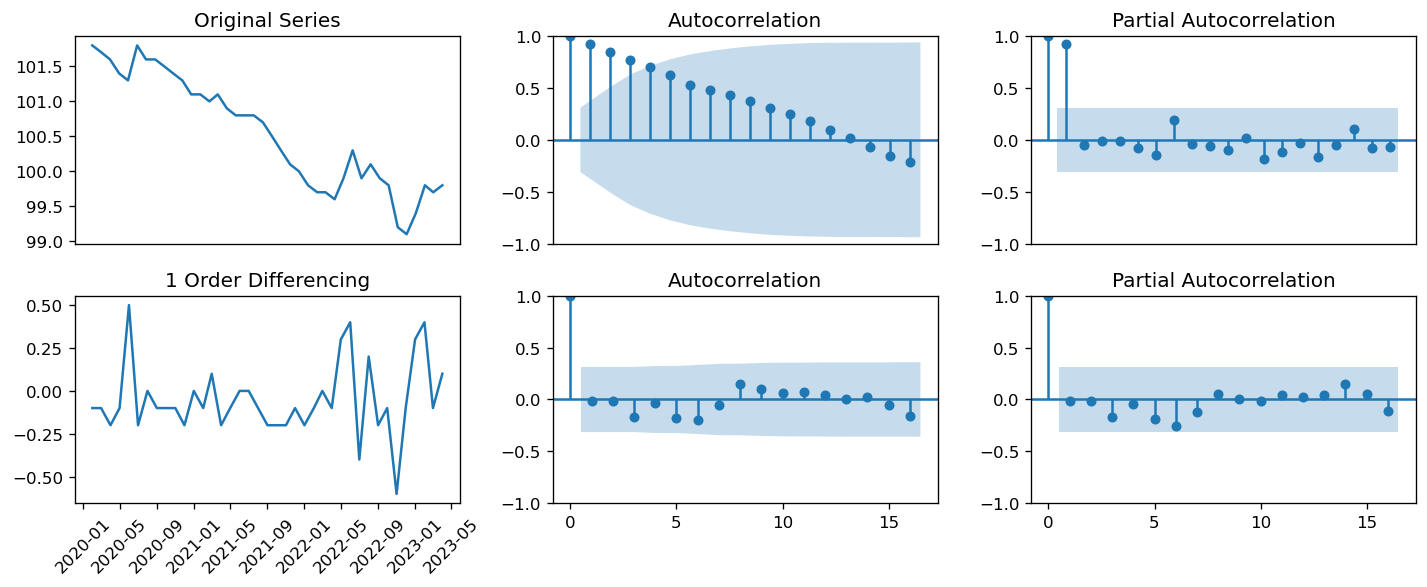

In [67]:
timeseries_eda(arima_train, '08')

##### ARIMA
Use auto_arima to find the best model.

0
Performing stepwise search to minimize aic
 ARIMA(1,2,1)(1,0,1)[12]             : AIC=inf, Time=0.28 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=19.216, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=12.656, Time=0.04 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=inf, Time=0.11 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=10.708, Time=0.02 sec
 ARIMA(1,2,0)(0,0,1)[12]             : AIC=12.682, Time=0.08 sec
 ARIMA(1,2,0)(1,0,1)[12]             : AIC=inf, Time=0.25 sec
 ARIMA(2,2,0)(0,0,0)[12]             : AIC=10.368, Time=0.02 sec
 ARIMA(2,2,0)(1,0,0)[12]             : AIC=12.273, Time=0.06 sec
 ARIMA(2,2,0)(0,0,1)[12]             : AIC=12.320, Time=0.06 sec
 ARIMA(2,2,0)(1,0,1)[12]             : AIC=inf, Time=0.37 sec
 ARIMA(3,2,0)(0,0,0)[12]             : AIC=8.316, Time=0.03 sec
 ARIMA(3,2,0)(1,0,0)[12]             : AIC=9.150, Time=0.12 sec
 ARIMA(3,2,0)(0,0,1)[12]             : AIC=9.818, Time=0.10 sec
 ARIMA(3,2,0)(1,0,1)[12]             : AIC=inf, Time=0.47 se

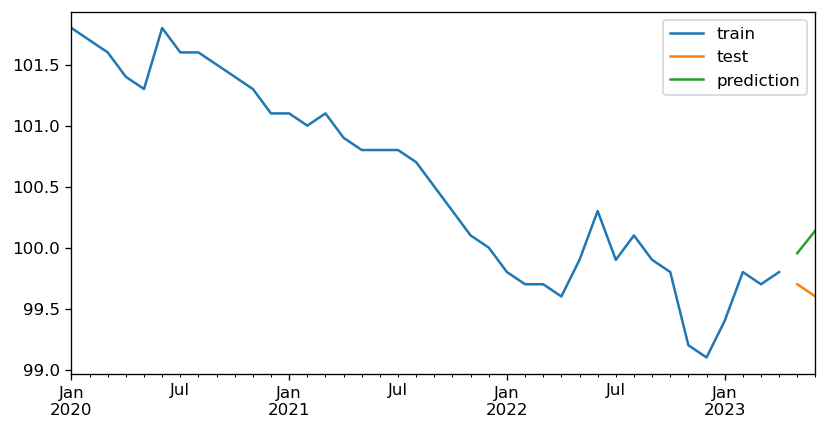

In [68]:
cat_model = find_best_model(arima_train['08'], arima_test['08'], colname='08')

##### Forecast the new CPI values

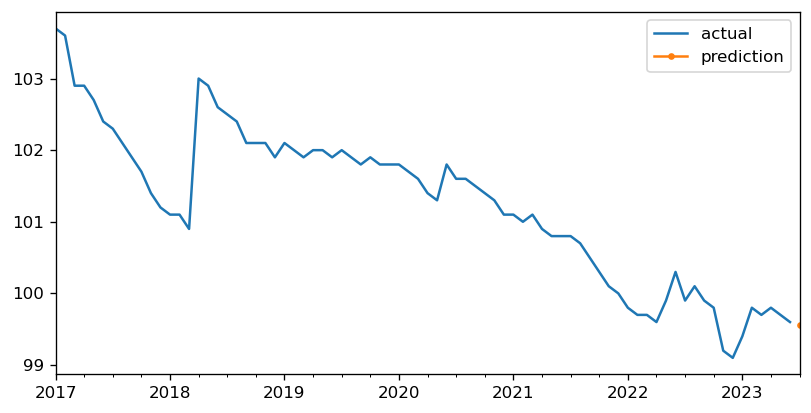

In [69]:
unseen_forecast = forecast_unseen_values(monthly_cpi_df, colname='08', model=cat_model, periods_to_predict=1, 
                       forecast_start_date='2023-07-01')

In [70]:
unseen_forecast

Prediction
2023-07-01   99.558165

### Category 9: Recreation and culture
##### Review the time series

SEASONAL DECOMPOSITION


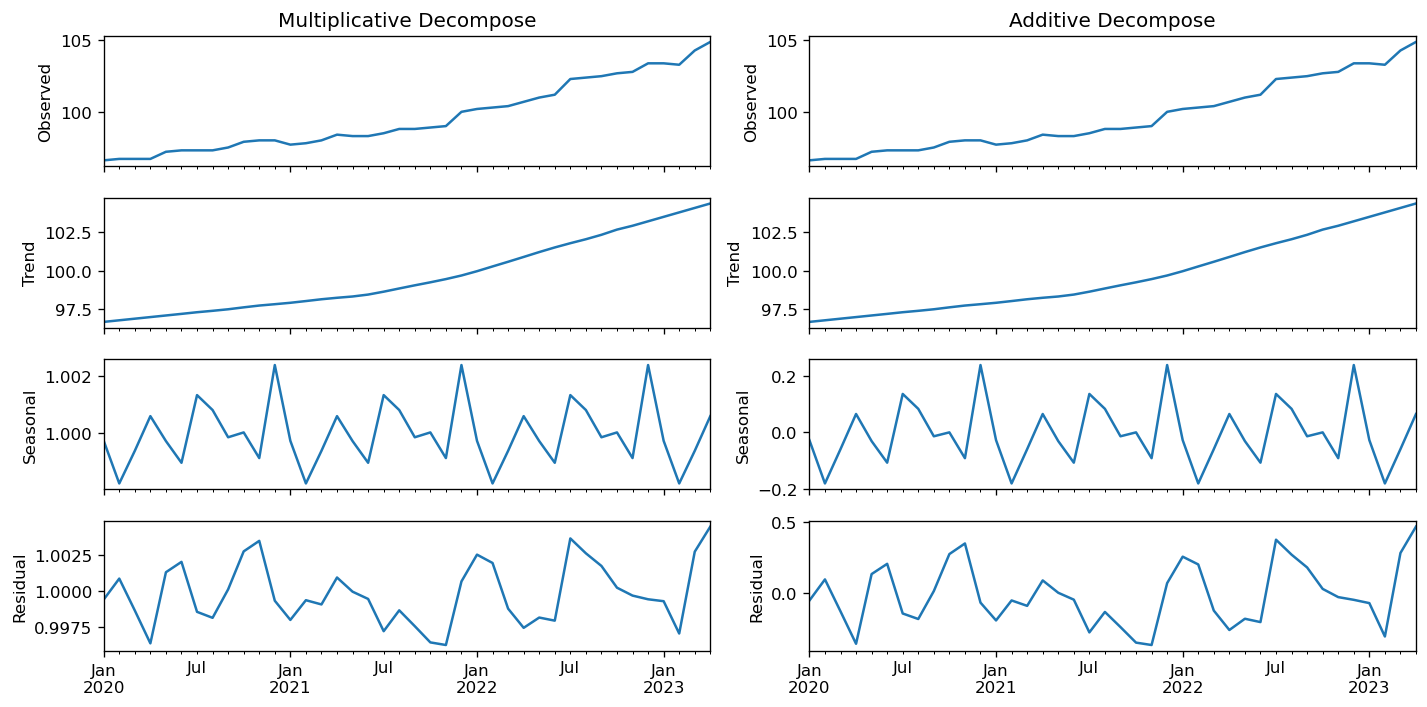



STATIONARITY CHECK
 => Series is not Stationary at d=0, P-Value=0.9985


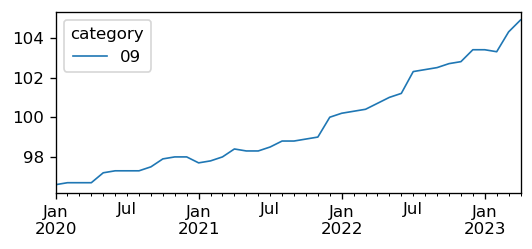



 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.
 => Differencing factor: d=1


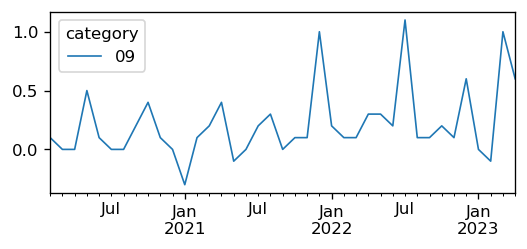



PLOT ACF AND PACF GRAPHS


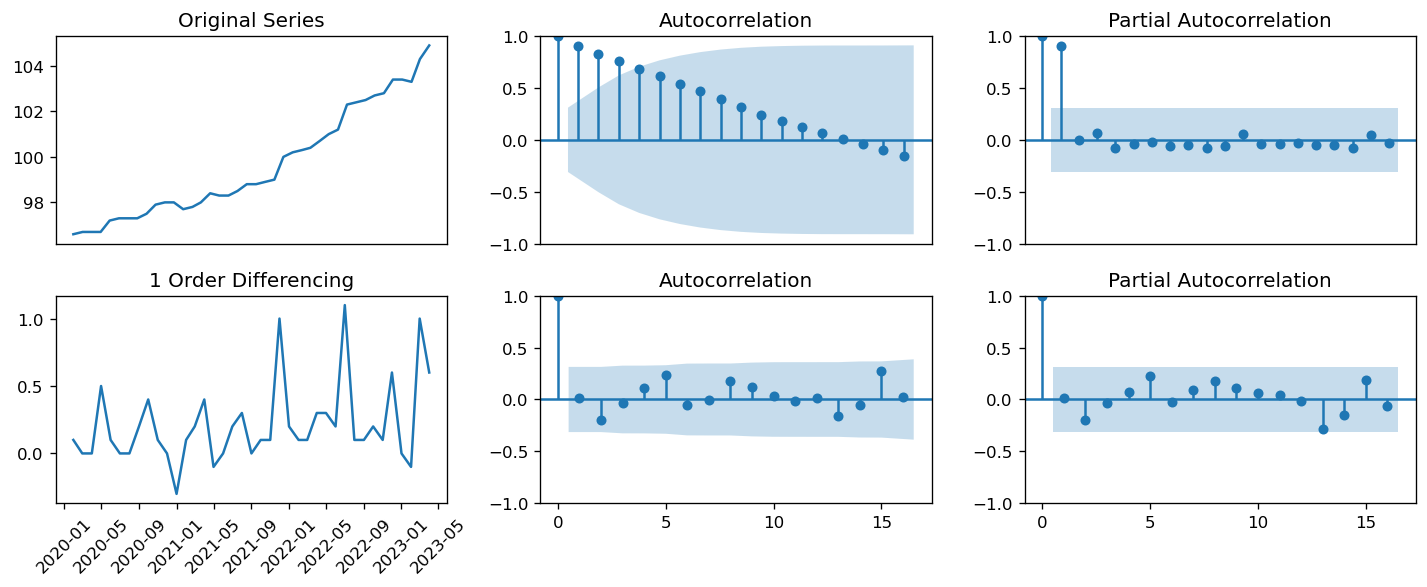

In [71]:
timeseries_eda(arima_train, '09')

##### ARIMA
Use auto_arima to find the best model.

0
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=20.248, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=24.222, Time=0.07 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=24.210, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=34.320, Time=0.03 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=22.240, Time=0.11 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=22.240, Time=0.07 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=22.237, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=22.230, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=inf, Time=0.10 sec

Best model:  ARIMA(0,1,0)(0,0,0)[12] intercept
Total fit time: 1.122 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   40
Model:       

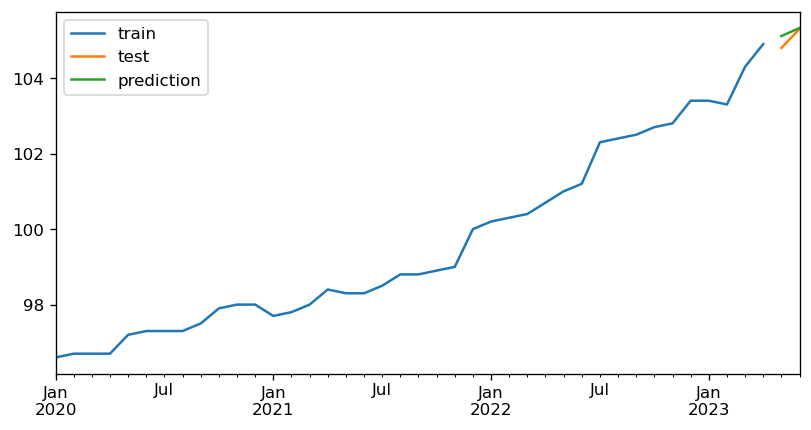

In [72]:
cat_model = find_best_model(arima_train['09'], arima_test['09'], colname='09')

##### Forecast the new CPI values

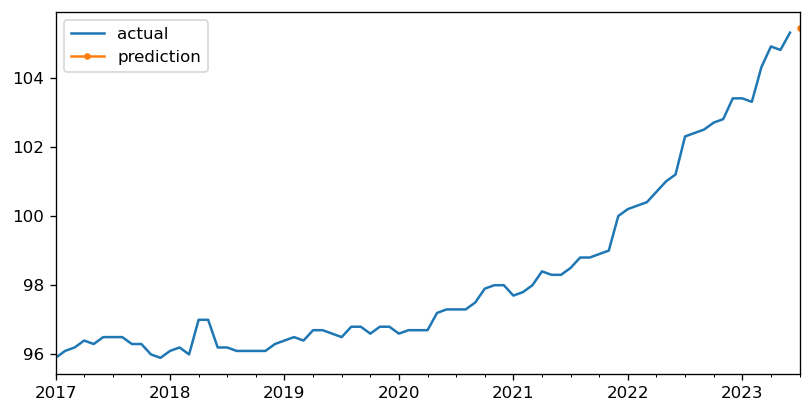

In [73]:
unseen_forecast = forecast_unseen_values(monthly_cpi_df, colname='09', model=cat_model, periods_to_predict=1, 
                       forecast_start_date='2023-07-01')

In [74]:
unseen_forecast

Prediction
2023-07-01  105.422078

### Category 10: Education
##### Review the time series

SEASONAL DECOMPOSITION


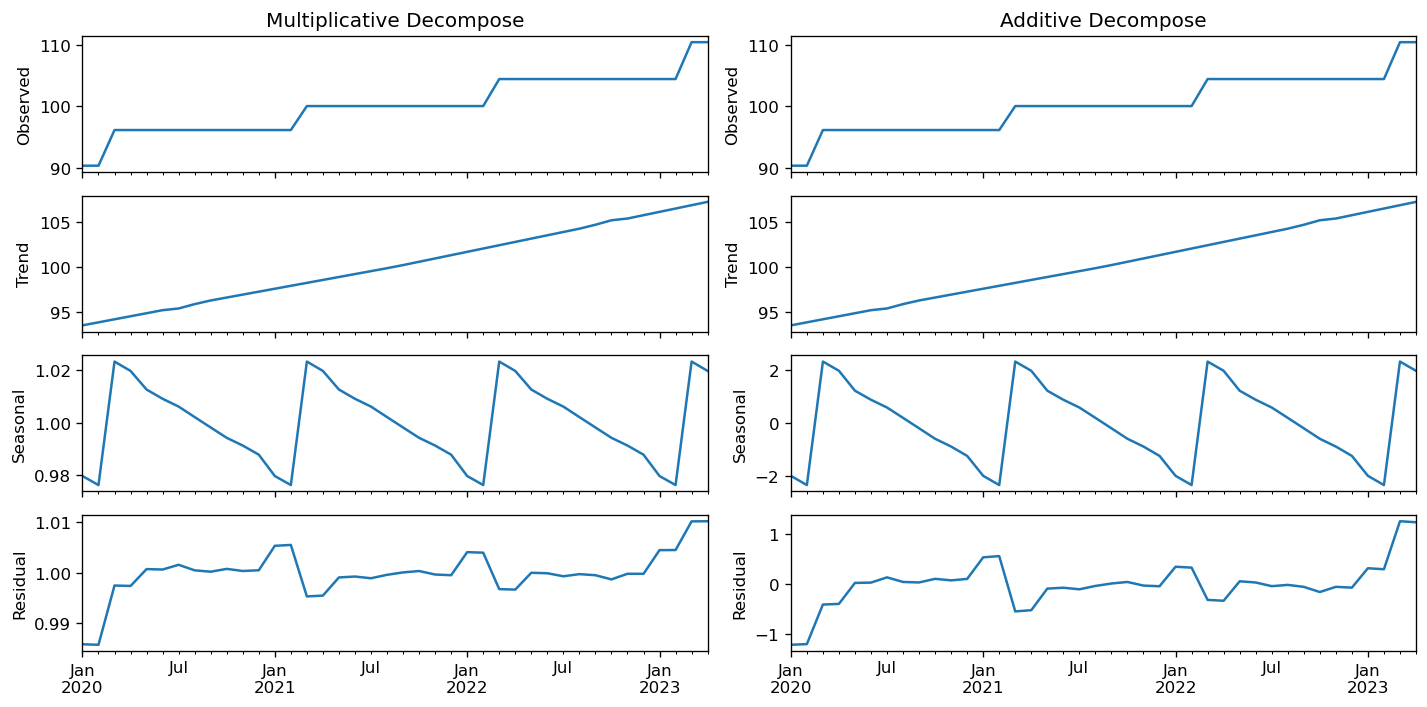



STATIONARITY CHECK
 => Series is not Stationary at d=0, P-Value=0.7385


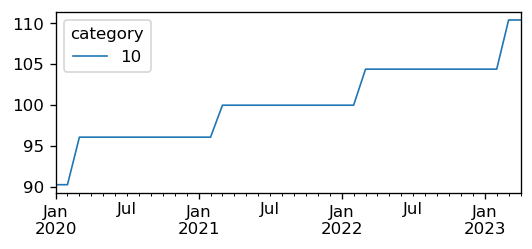



 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.
 => Differencing factor: d=1


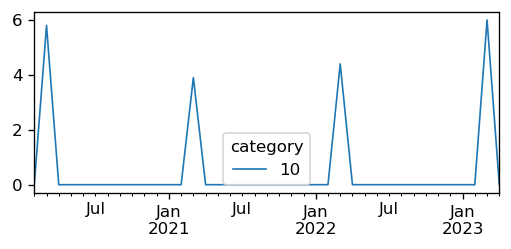



PLOT ACF AND PACF GRAPHS


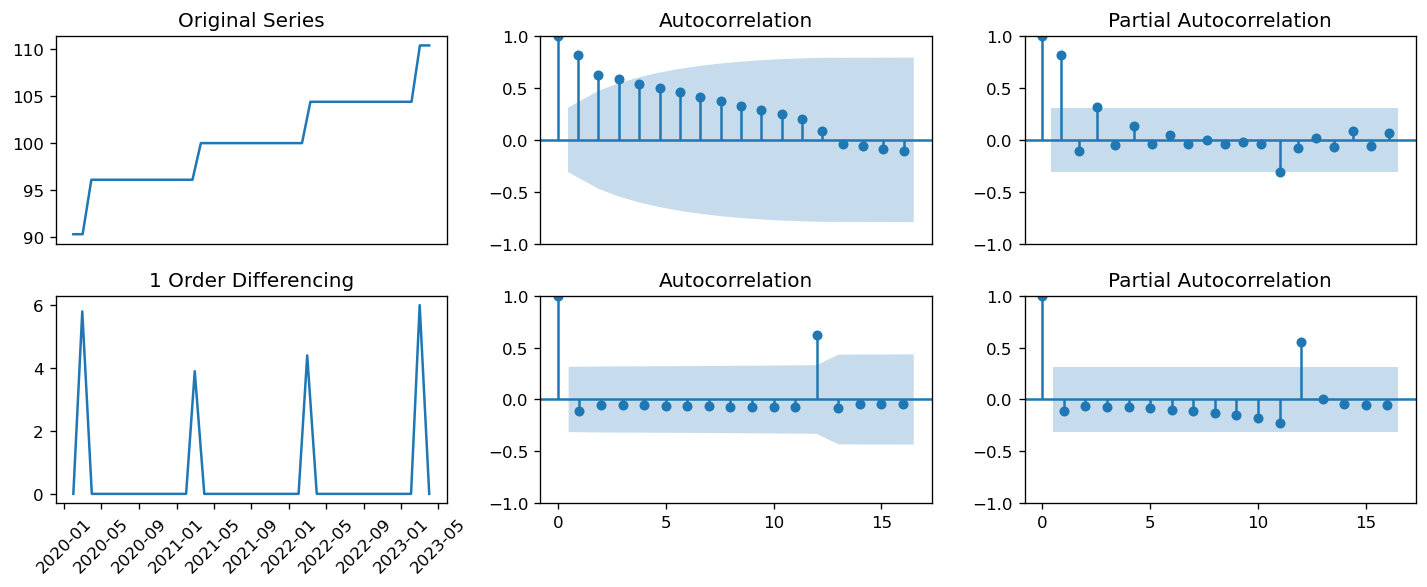

In [75]:
timeseries_eda(arima_train, '10')

##### ARIMA
Use auto_arima to find the best model.

0
Performing stepwise search to minimize aic
 ARIMA(1,2,1)(1,0,1)[12]             : AIC=inf, Time=0.17 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=174.514, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=inf, Time=0.07 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=inf, Time=0.11 sec
 ARIMA(0,2,0)(1,0,0)[12]             : AIC=inf, Time=0.05 sec
 ARIMA(0,2,0)(0,0,1)[12]             : AIC=inf, Time=0.19 sec
 ARIMA(0,2,0)(1,0,1)[12]             : AIC=inf, Time=0.29 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=159.394, Time=0.02 sec
 ARIMA(1,2,0)(0,0,1)[12]             : AIC=inf, Time=0.11 sec
 ARIMA(1,2,0)(1,0,1)[12]             : AIC=95.439, Time=0.30 sec
 ARIMA(1,2,0)(2,0,1)[12]             : AIC=inf, Time=0.65 sec
 ARIMA(1,2,0)(1,0,2)[12]             : AIC=inf, Time=0.57 sec
 ARIMA(1,2,0)(0,0,2)[12]             : AIC=inf, Time=0.41 sec
 ARIMA(1,2,0)(2,0,0)[12]             : AIC=inf, Time=0.46 sec
 ARIMA(1,2,0)(2,0,2)[12]             : AIC=inf, Time=1.34 sec
 ARIMA(2,2,0)(

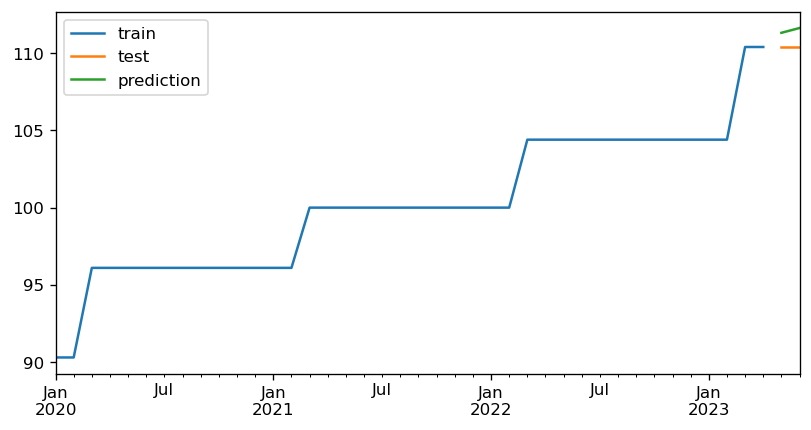

In [76]:
cat_model = find_best_model(arima_train['10'], arima_test['10'], colname='10')

##### Forecast the new CPI values

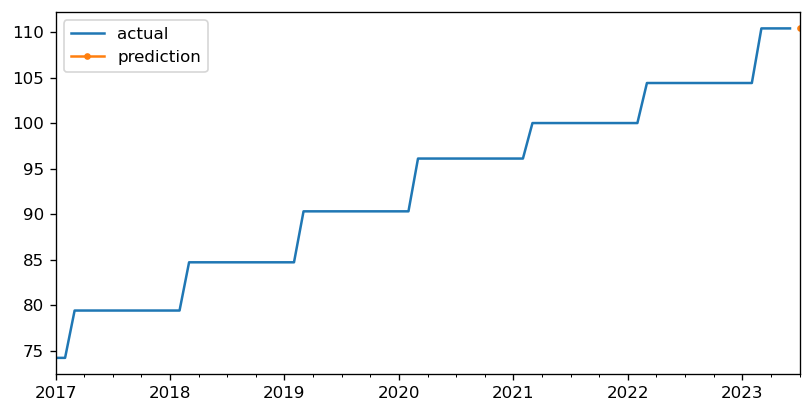

In [77]:
unseen_forecast = forecast_unseen_values(monthly_cpi_df, colname='10', model=cat_model, periods_to_predict=1, 
                       forecast_start_date='2023-07-01')

In [78]:
unseen_forecast

Prediction
2023-07-01  110.400016

### Category 11: Restaurants and hotels
##### Review the time series

SEASONAL DECOMPOSITION


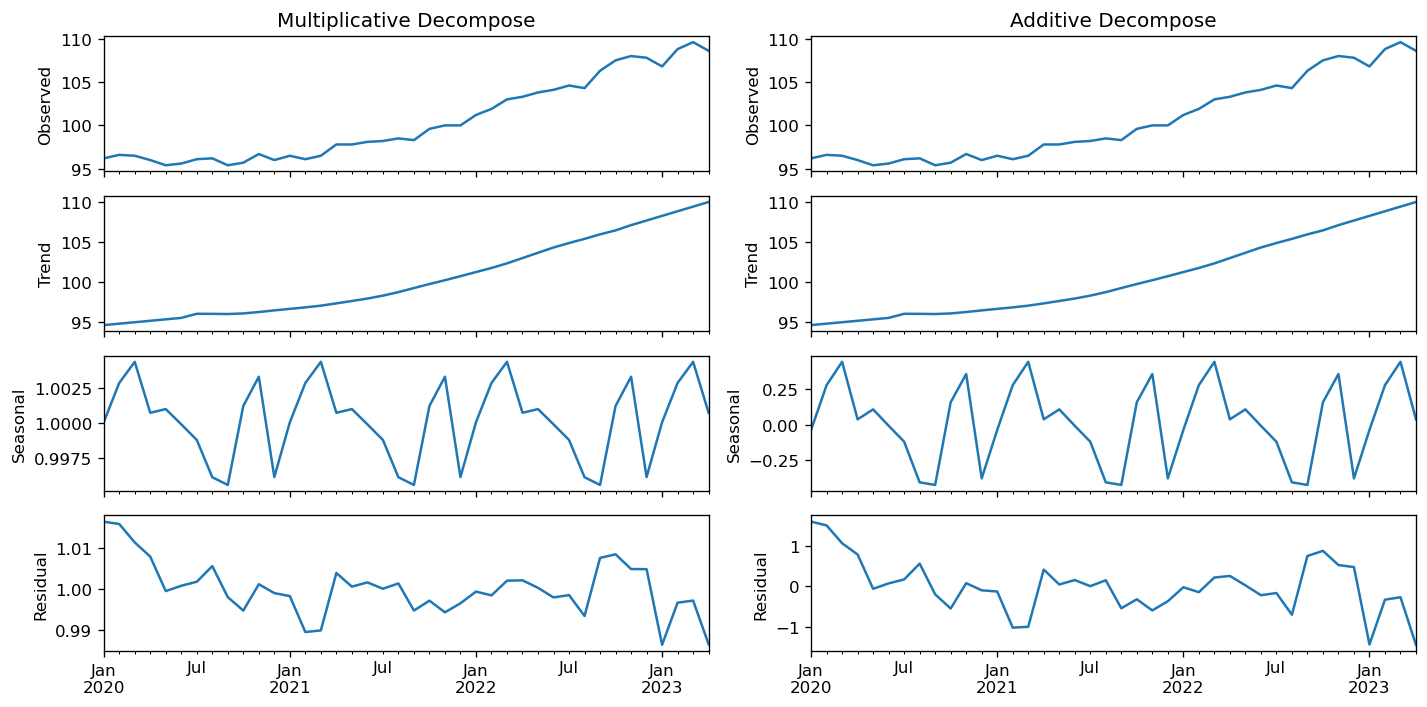



STATIONARITY CHECK
 => Series is not Stationary at d=0, P-Value=0.9975


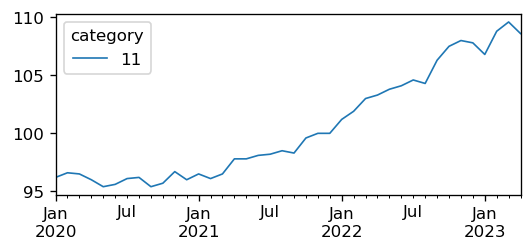



 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.
 => Differencing factor: d=1


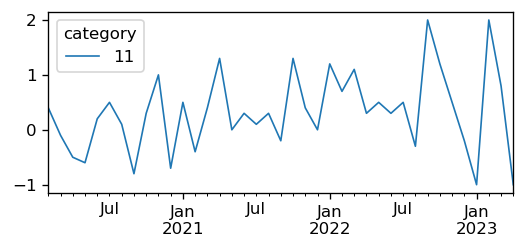



PLOT ACF AND PACF GRAPHS


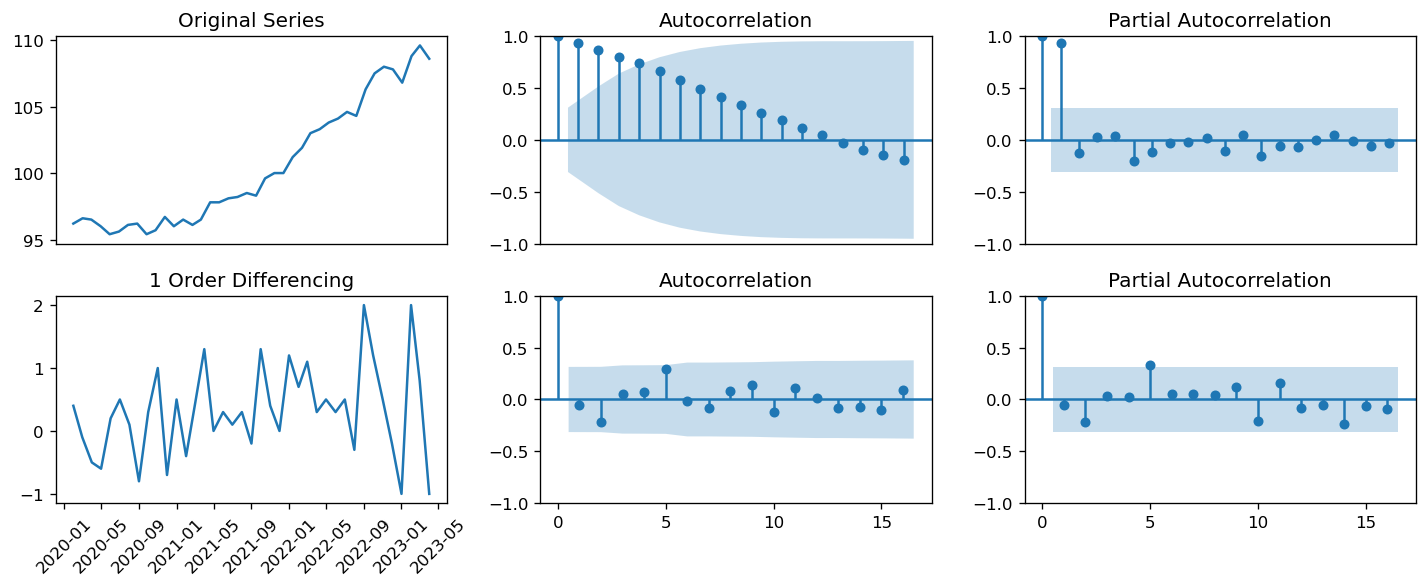

In [79]:
timeseries_eda(arima_train, '11')

##### ARIMA
Use auto_arima to find the best model.

0
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=88.588, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=92.471, Time=0.05 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=92.340, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=93.612, Time=0.01 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=90.580, Time=0.04 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=90.546, Time=0.05 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=90.482, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=90.399, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=92.085, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,0,0)[12] intercept
Total fit time: 0.861 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   40
Model:    

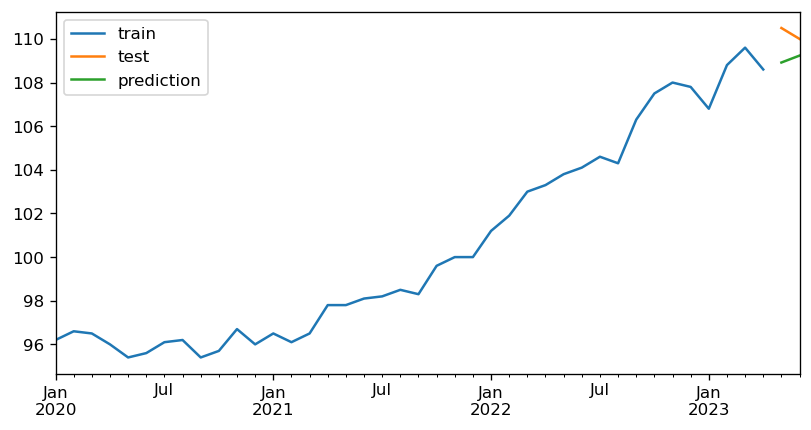

In [80]:
cat_model = find_best_model(arima_train['11'], arima_test['11'], colname='11')

##### Forecast the new CPI values

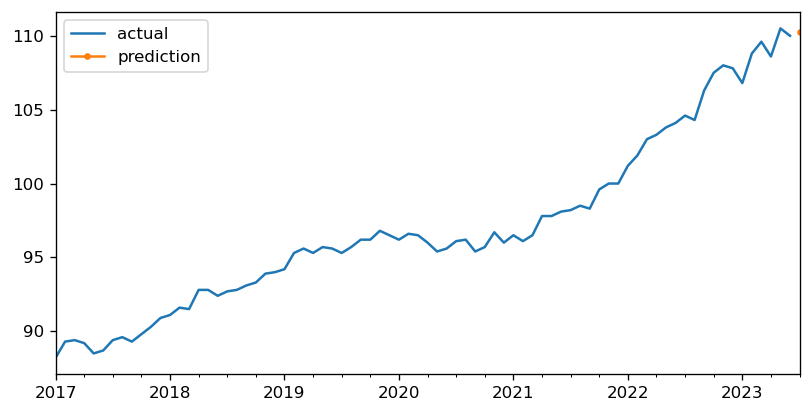

In [81]:
unseen_forecast = forecast_unseen_values(monthly_cpi_df, colname='11', model=cat_model, periods_to_predict=1, 
                       forecast_start_date='2023-07-01')

In [82]:
unseen_forecast

Prediction
2023-07-01  110.283117

### Category 12: Miscellaneous goods and services
##### Review the time series

SEASONAL DECOMPOSITION


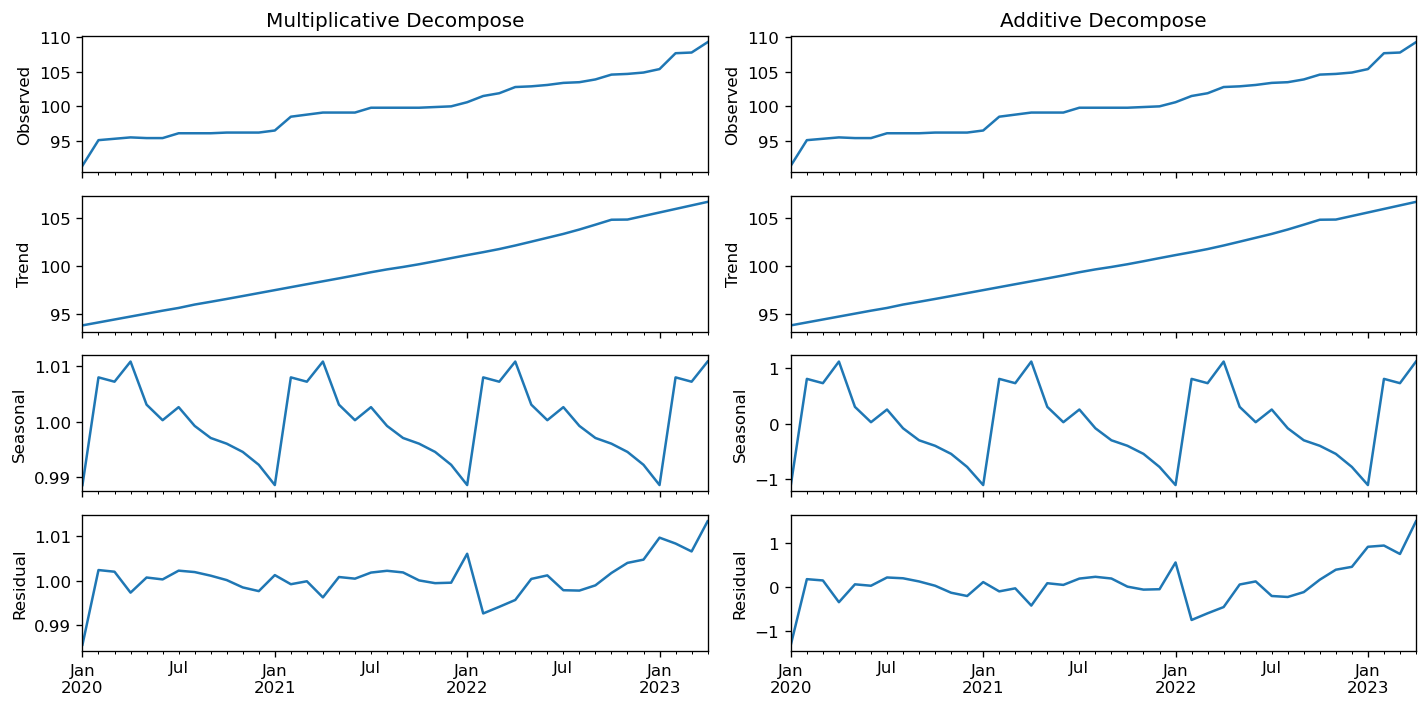



STATIONARITY CHECK
 => Series is not Stationary at d=0, P-Value=0.9227


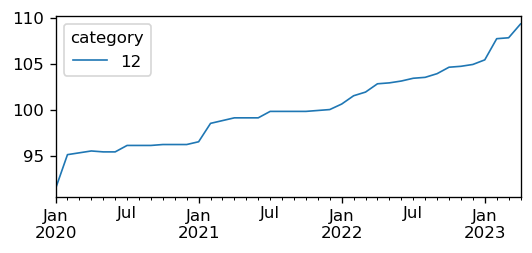



 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.
 => Differencing factor: d=1


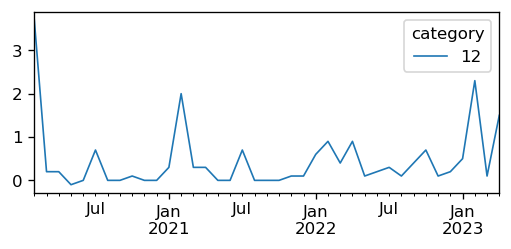



PLOT ACF AND PACF GRAPHS


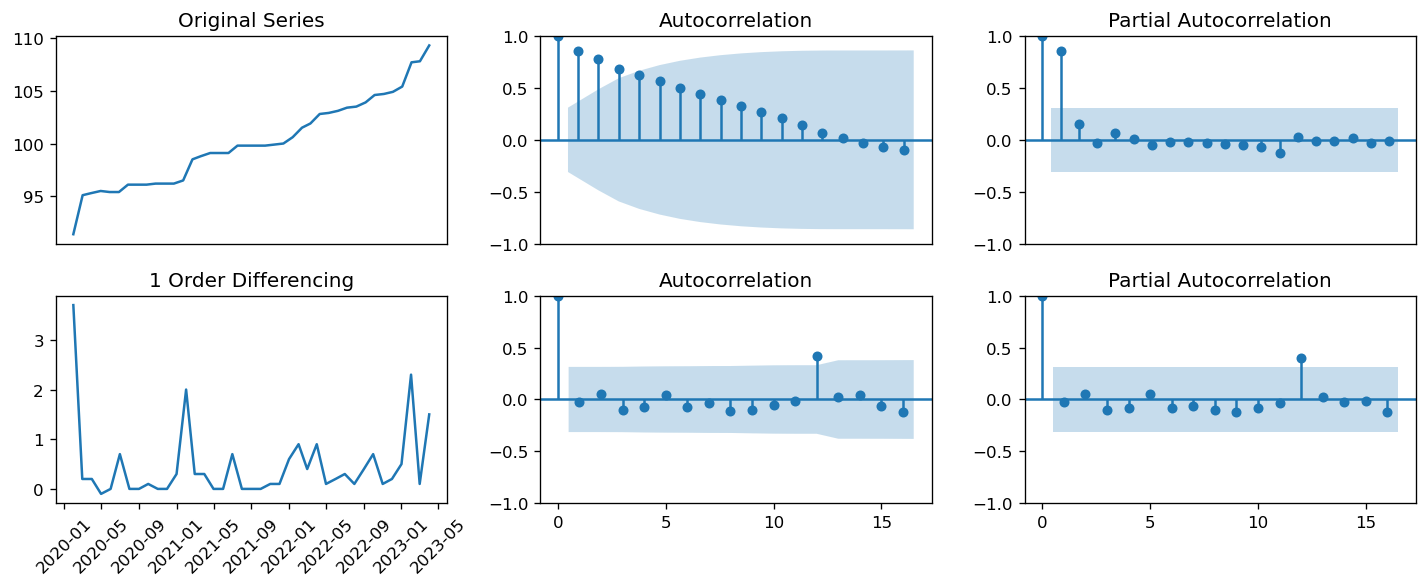

In [83]:
timeseries_eda(arima_train, '12')

##### ARIMA
Use auto_arima to find the best model.

0
Performing stepwise search to minimize aic
 ARIMA(1,2,1)(1,0,1)[12]             : AIC=inf, Time=0.18 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=103.922, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=85.115, Time=0.04 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=inf, Time=0.12 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=98.118, Time=0.03 sec
 ARIMA(1,2,0)(2,0,0)[12]             : AIC=87.071, Time=0.34 sec
 ARIMA(1,2,0)(1,0,1)[12]             : AIC=86.920, Time=0.17 sec
 ARIMA(1,2,0)(0,0,1)[12]             : AIC=inf, Time=0.16 sec
 ARIMA(1,2,0)(2,0,1)[12]             : AIC=inf, Time=0.74 sec
 ARIMA(0,2,0)(1,0,0)[12]             : AIC=93.412, Time=0.05 sec
 ARIMA(2,2,0)(1,0,0)[12]             : AIC=85.529, Time=0.07 sec
 ARIMA(1,2,1)(1,0,0)[12]             : AIC=78.959, Time=0.21 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=inf, Time=0.11 sec
 ARIMA(1,2,1)(2,0,0)[12]             : AIC=80.786, Time=0.35 sec
 ARIMA(1,2,1)(0,0,1)[12]             : AIC=inf, Time=0.25 s

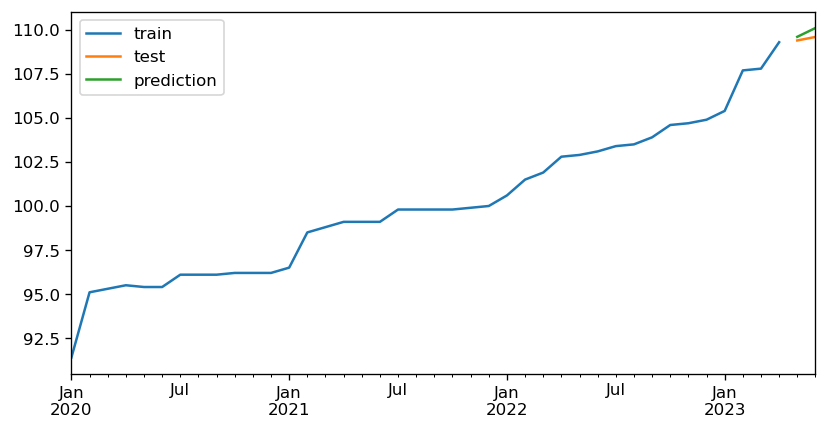

In [84]:
cat_model = find_best_model(arima_train['12'], arima_test['12'], colname='12')

##### Forecast the new CPI values

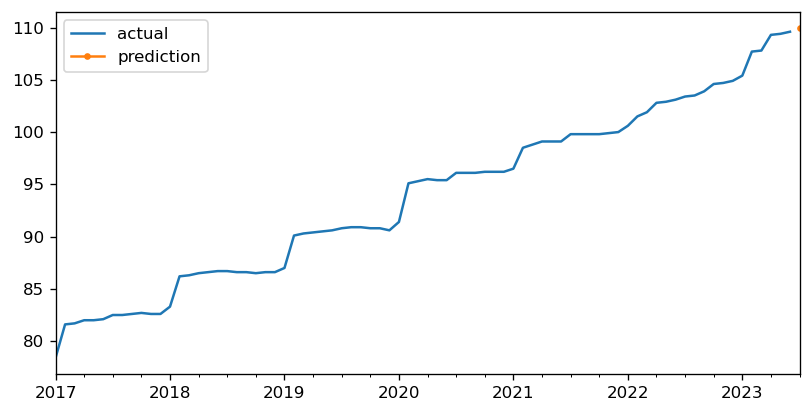

In [85]:
unseen_forecast = forecast_unseen_values(monthly_cpi_df, colname='12', model=cat_model, periods_to_predict=1, 
                       forecast_start_date='2023-07-01')

In [86]:
unseen_forecast

Prediction
2023-07-01  109.917946

### Headline CPI
##### Review the time series

SEASONAL DECOMPOSITION


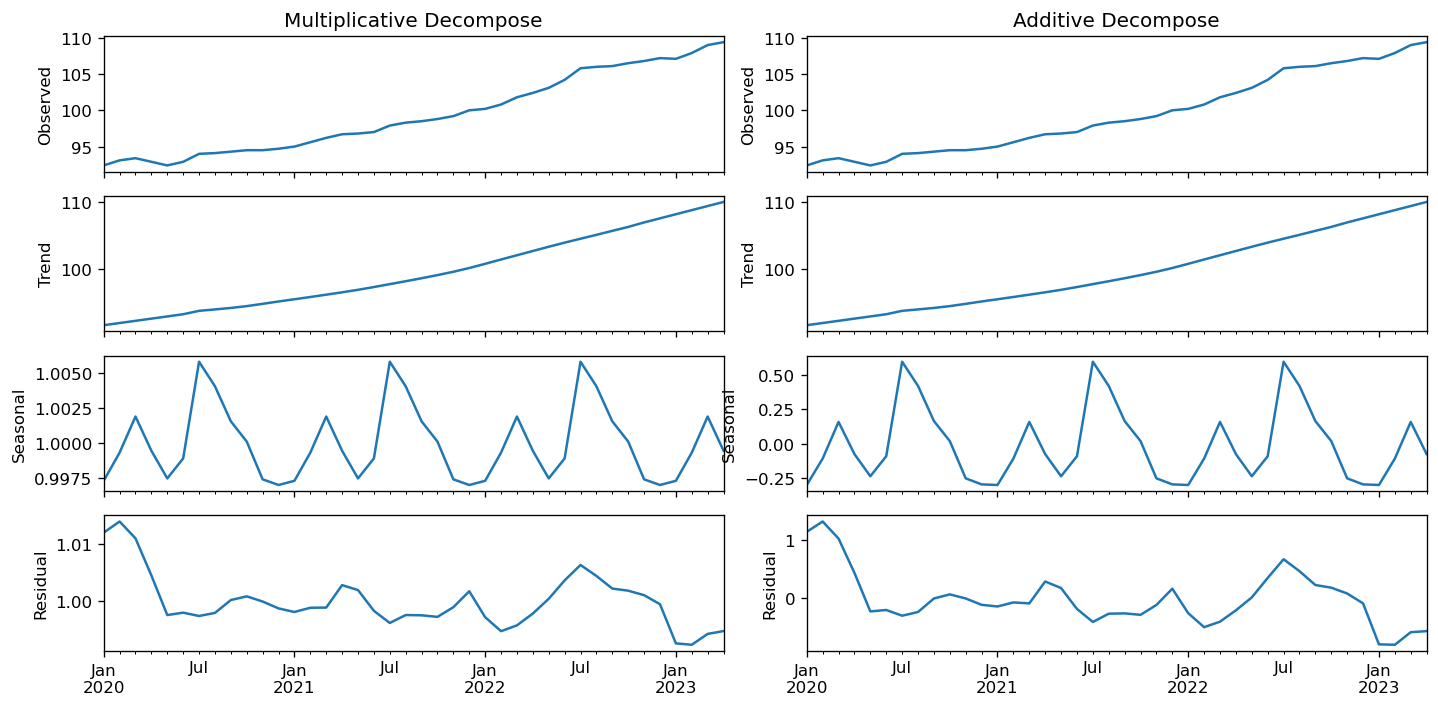



STATIONARITY CHECK
 => Series is not Stationary at d=0, P-Value=0.9988


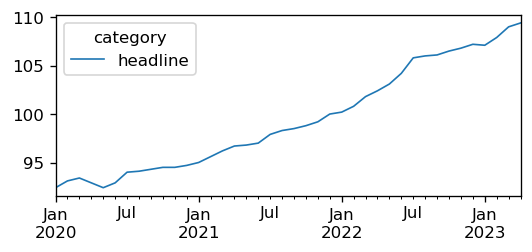

 => Series is not Stationary at d=1, P-Value=0.5212


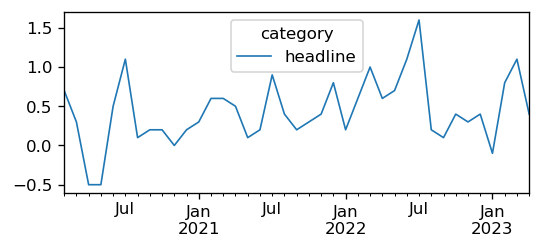



 => P-Value = 0.0381. Rejecting Null Hypothesis.
 => Series is Stationary.
 => Differencing factor: d=2


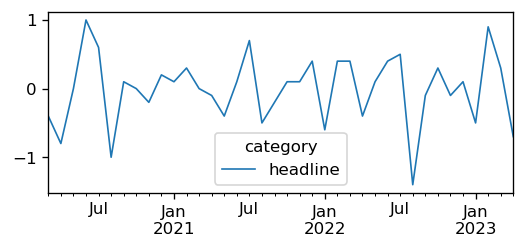



PLOT ACF AND PACF GRAPHS


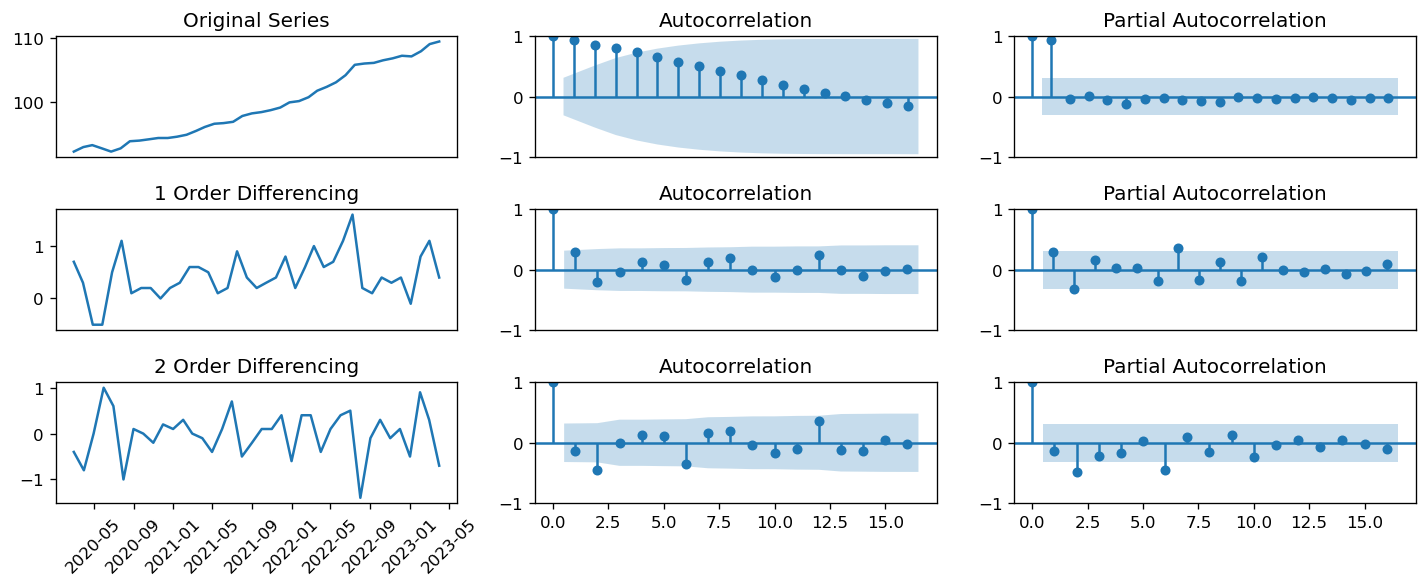

In [87]:
timeseries_eda(arima_train, 'headline')

##### ARIMA
Use auto_arima to find the best model.

0
Performing stepwise search to minimize aic
 ARIMA(1,2,1)(1,0,1)[12]             : AIC=38.875, Time=0.19 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=57.040, Time=0.03 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=49.208, Time=0.07 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=45.770, Time=0.08 sec
 ARIMA(1,2,1)(0,0,1)[12]             : AIC=44.194, Time=0.22 sec
 ARIMA(1,2,1)(1,0,0)[12]             : AIC=39.560, Time=0.18 sec
 ARIMA(1,2,1)(2,0,1)[12]             : AIC=inf, Time=0.82 sec
 ARIMA(1,2,1)(1,0,2)[12]             : AIC=inf, Time=0.82 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=47.718, Time=0.05 sec
 ARIMA(1,2,1)(0,0,2)[12]             : AIC=42.789, Time=0.26 sec
 ARIMA(1,2,1)(2,0,0)[12]             : AIC=39.553, Time=0.25 sec
 ARIMA(1,2,1)(2,0,2)[12]             : AIC=inf, Time=0.93 sec
 ARIMA(0,2,1)(1,0,1)[12]             : AIC=42.169, Time=0.27 sec
 ARIMA(1,2,0)(1,0,1)[12]             : AIC=inf, Time=0.31 sec
 ARIMA(2,2,1)(1,0,1)[12]             : AIC=35.775, Time=0

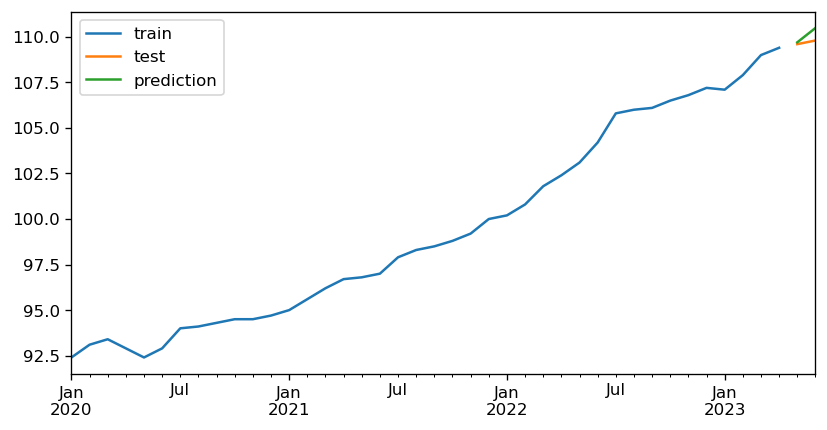

In [88]:
cat_model = find_best_model(arima_train['headline'], arima_test['headline'], colname='headline')

##### Forecast the new CPI values

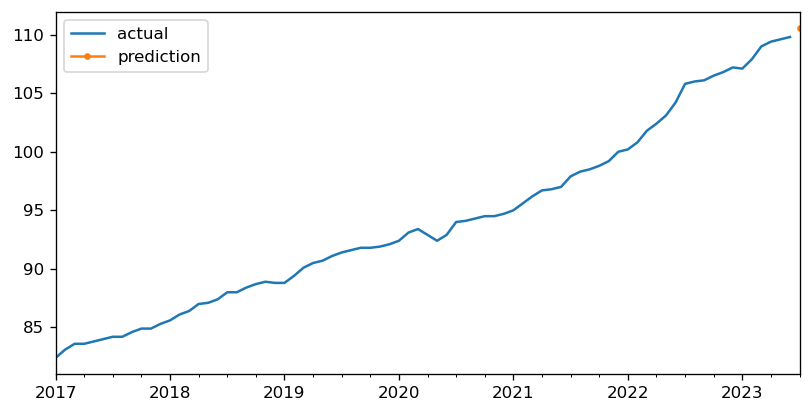

In [89]:
unseen_forecast = forecast_unseen_values(monthly_cpi_df, colname='headline', model=cat_model, periods_to_predict=1, 
                       forecast_start_date='2023-07-01')

In [90]:
unseen_forecast

Prediction
2023-07-01  110.532851

### Review Test Prediction Score

In [91]:
test_prediction_df = pd.DataFrame.from_dict(cpi_test_dict,orient='index', columns=['Year_Month', 'Value']).reset_index().rename(columns={'index': 'ID'})

In [92]:
RMSE = sqrt(mean_squared_error(arima_test[arima_test.index=='2023-06-01'].transpose(), test_prediction_df['Value']))
RMSE

0.9943604535690346

### Create Dataframe for Submission

In [93]:
prediction_df = pd.DataFrame.from_dict(cpi_dict,orient='index', columns=['Year_Month', 'Value']).reset_index().rename(columns={'index': 'ID'})

In [94]:
prediction_df

ID  Year_Month       Value
0         01  2023-07-01  119.151592
1         02  2023-07-01  111.093681
2         03  2023-07-01  104.450649
3         04  2023-07-01  107.157154
4         05  2023-07-01  107.588860
5         06  2023-07-01  110.814572
6         07  2023-07-01  112.815944
7         08  2023-07-01   99.558165
8         09  2023-07-01  105.422078
9         10  2023-07-01  110.400016
10        11  2023-07-01  110.283117
11        12  2023-07-01  109.917946
12  headline  2023-07-01  110.532851

In [95]:
pred_month = pd.to_datetime(prediction_df['Year_Month'].unique()[0]).strftime('%B')
pred_month

'July'

In [96]:
# drop the month from the dataframe
prediction_df.drop(['Year_Month'], axis=1, inplace=True)

In [97]:
# Create a dictionary to update the category names to allow a submission to Zindi.
# month="May"
pred_category_dict = {"01":pred_month+"_food and non-alcoholic beverages",
                      "02":pred_month+"_alcoholic beverages and tobacco",
                      "03":pred_month+"_clothing and footwear",
                      "04":pred_month+"_housing and utilities",
                      "05":pred_month+"_household contents and services",
                      "06":pred_month+"_health",
                      "07":pred_month+"_transport",
                      "08":pred_month+"_communication",
                      "09":pred_month+"_recreation and culture",
                      "10":pred_month+"_education",
                      "11":pred_month+"_restaurants and hotels",
                      "12":pred_month+"_miscellaneous goods and services",
                      "headline":pred_month+"_headline CPI"
}

In [98]:
prediction_df = prediction_df.replace(pred_category_dict)
prediction_df

ID       Value
0   July_food and non-alcoholic beverages  119.151592
1    July_alcoholic beverages and tobacco  111.093681
2              July_clothing and footwear  104.450649
3              July_housing and utilities  107.157154
4    July_household contents and services  107.588860
5                             July_health  110.814572
6                          July_transport  112.815944
7                      July_communication   99.558165
8             July_recreation and culture  105.422078
9                          July_education  110.400016
10            July_restaurants and hotels  110.283117
11  July_miscellaneous goods and services  109.917946
12                      July_headline CPI  110.532851

In [99]:
# output to csv file
prediction_df.to_csv('v18_arima_ev.csv', index = 0)